<a href="https://colab.research.google.com/github/DIFACQUIM/De-Novo_DNMT1/blob/main/04_t-SNE_fingerprints(MACCS%2CECFP4).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code from: https://github.com/DIFACQUIM/Food_chemicals_characterization/blob/main/codes/tSNE-MACCS%2C%20ECFP4%2C%20ECFP6.ipynb

In [ ]:
from IPython.utils import io
import tqdm.notebook
import os, sys, random
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
      # Install rdkit
      !pip -q install rdkit
      pbar.update(100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#Import libraries
import pandas as pd
import numpy as np

import rdkit
from rdkit import Chem, DataStructs, RDConfig
from rdkit.Chem import Descriptors, PandasTools, AllChem, MACCSkeys, Pharm2D
from rdkit.Chem.Pharm2D import Gobbi_Pharm2D, Generate
from scipy.spatial.distance import pdist

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#De novo compounds
df=pd.read_csv("https://raw.githubusercontent.com/DIFACQUIM/De-Novo_DNMT1/main/alvaBuilder/Alva2023_5575.csv", delimiter=",")
print(df.shape)
df.head(2)

(5575, 9)


SMILES   DATABASE          ID  \
0      OCCCNC(=O)c1cc(nc2cc(n[n]12)C(F)(F)F)-c1ccco1  AB_CDDNMT  ABCDT01_01   
1  CC(O)C(=O)OCN=C1NC(=Nc2ccccc12)c1cc(ccc1Br)OC(...  AB_CDDNMT  ABCDT01_02   

       PROGRAM     FRAGMENTS      DATASET  PROGRAM_SCORE  \
0  AlvaBuilder  ChemDiv DNMT  AB_CDDNMT01              1   
1  AlvaBuilder  ChemDiv DNMT  AB_CDDNMT01              1   

                                       SMILES_chiral  \
0        O=C(NCCCO)c1cc(-c2ccco2)nc2cc(C(F)(F)F)nn12   
1  CC(=O)C(O)OCN=c1[nH]c(-c2cc(OC(=O)O)ccc2Br)nc2...   

                                    SMILES_no_chiral  
0        O=C(NCCCO)c1cc(-c2ccco2)nc2cc(C(F)(F)F)nn12  
1  CC(=O)C(O)OCN=c1[nH]c(-c2cc(OC(=O)O)ccc2Br)nc2...

In [ ]:
#DNMT1 actives
DNMT=pd.read_csv("https://github.com/DIFACQUIM/De-Novo_DNMT1/raw/main/DNMT1_10micM_285_curated.csv", delimiter=",")
DNMT.head(2)

Molecule ChEMBL ID Molecule Name  Molecule Max Phase  Molecular Weight  \
0      CHEMBL3087498           NaN                   0            618.58   
1      CHEMBL2171169           NaN                   0            540.67   

   #RO5 Violations  AlogP Compound Key  \
0                1   3.61      SGC0946   
1                1   2.25         FED1   

                                              Smiles Standard Type  \
0  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...          IC50   
1  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)C[C@H]1O[C...          IC50   

  Standard Relation  ...  Target Organism     Target Type  Document ChEMBL ID  \
0               '='  ...     Homo sapiens  SINGLE PROTEIN       CHEMBL4477246   
1               '='  ...     Homo sapiens  SINGLE PROTEIN       CHEMBL4477246   

   Source ID     Source Description      Document Journal  Document Year  \
0          1  Scientific Literature  Bioorg Med Chem Lett         2016.0   
1          1  Scientific Literature  Bioorg Med Chem Lett         2016.0   

   Cell ChEMBL ID  Properties  \
0             NaN         NaN   
1             NaN         NaN   

                                          NEW_SMILES  
0  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cc...  
1  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cn...  

[2 rows x 46 columns]

In [ ]:
#Add Database column for identification
DNMT['DATABASE'] = "DNMT1"

In [ ]:
#List columns of both dataframes
print(df.columns)
print(DNMT.columns)

Index(['SMILES', 'DATABASE', 'ID', 'PROGRAM', 'FRAGMENTS', 'DATASET',
       'PROGRAM_SCORE', 'SMILES_chiral', 'SMILES_no_chiral'],
      dtype='object')
Index(['Molecule ChEMBL ID', 'Molecule Name', 'Molecule Max Phase',
       'Molecular Weight', '#RO5 Violations', 'AlogP', 'Compound Key',
       'Smiles', 'Standard Type', 'Standard Relation', 'Standard Value',
       'Standard Units', 'pChEMBL Value', 'Data Validity Comment', 'Comment',
       'Uo Units', 'Ligand Efficiency BEI', 'Ligand Efficiency LE',
       'Ligand Efficiency LLE', 'Ligand Efficiency SEI', 'Potential Duplicate',
       'Assay ChEMBL ID', 'Assay Description', 'Assay Type', 'BAO Format ID',
       'BAO Label', 'Assay Organism', 'Assay Tissue ChEMBL ID',
       'Assay Tissue Name', 'Assay Cell Type', 'Assay Subcellular Fraction',
       'Assay Parameters', 'Assay Variant Accession', 'Assay Variant Mutation',
       'Target ChEMBL ID', 'Target Name', 'Target Organism', 'Target Type',
       'Document ChEMBL ID', 'Sou

In [ ]:
# Select columns
df = df[['ID', 'SMILES_chiral', 'DATABASE']]
DNMT = DNMT[['Molecule ChEMBL ID', 'NEW_SMILES', 'DATABASE']]

# Change names
df.columns = ["ID", "SMILES", "DATABASE"]
DNMT.columns = ["ID", "SMILES", "DATABASE"]

#Concatenate
DATA = pd.concat([DNMT, df], sort=False)
print(DATA.shape)
DATA.head()

(5860, 3)


ID                                             SMILES DATABASE
0  CHEMBL3087498  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cc...    DNMT1
1  CHEMBL2171169  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cn...    DNMT1
2    CHEMBL83747  O=C(NCCSSCCNC(=O)C(Cc1ccc(O)c(Br)c1)=NO)C(Cc1c...    DNMT1
3  CHEMBL4215326  COc1cc2c(=NC3CCN(C)CC3)cc(-c3ccc(C)o3)[nH]c2cc...    DNMT1
4  CHEMBL1201129                  N=c1ncn(C2CC(O)C(CO)O2)c(=O)[nH]1    DNMT1

In [ ]:
df_ECFP4 = pd.DataFrame([[int(y) for y in AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(x), 2, nBits=1024).ToBitString()] for x in DATA["SMILES"]])

In [ ]:
df_ECFP4.head(2)

0     1     2     3     4     5     6     7     8     9     ...  1014  \
0     0     1     0     0     0     0     0     0     0     0  ...     0   
1     0     1     0     0     0     1     0     0     0     0  ...     0   

   1015  1016  1017  1018  1019  1020  1021  1022  1023  
0     0     0     0     0     1     0     0     0     0  
1     0     0     0     0     1     0     0     0     0  

[2 rows x 1024 columns]

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
data_tsne = df_ECFP4.copy()
data_tsne = StandardScaler().fit_transform(data_tsne)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(data_tsne)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5860 samples in 0.054s...
[t-SNE] Computed neighbors for 5860 samples in 3.132s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5860
[t-SNE] Computed conditional probabilities for sample 2000 / 5860
[t-SNE] Computed conditional probabilities for sample 3000 / 5860
[t-SNE] Computed conditional probabilities for sample 4000 / 5860
[t-SNE] Computed conditional probabilities for sample 5000 / 5860
[t-SNE] Computed conditional probabilities for sample 5860 / 5860
[t-SNE] Mean sigma: 11.622554
[t-SNE] KL divergence after 250 iterations with early exaggeration: 101.510002
[t-SNE] KL divergence after 1000 iterations: 2.507692


In [ ]:
label = DATA[["DATABASE", "ID", "SMILES"]]
label = label.to_numpy()

In [ ]:
# Concatenate arrays
arr = np.concatenate((label, tsne_results), axis = 1)

In [ ]:
# New dataframe
tsne_dataset = pd.DataFrame(data=arr, columns = ['DATABASE','ID', 'SMILES','dimension1', 'dimension2'] )
tsne_dataset.head(2)

DATABASE             ID                                             SMILES  \
0    DNMT1  CHEMBL3087498  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cc...   
1    DNMT1  CHEMBL2171169  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cn...   

  dimension1 dimension2  
0 -43.176205  61.677658  
1 -43.160976  61.633163

<Figure size 640x480 with 0 Axes>

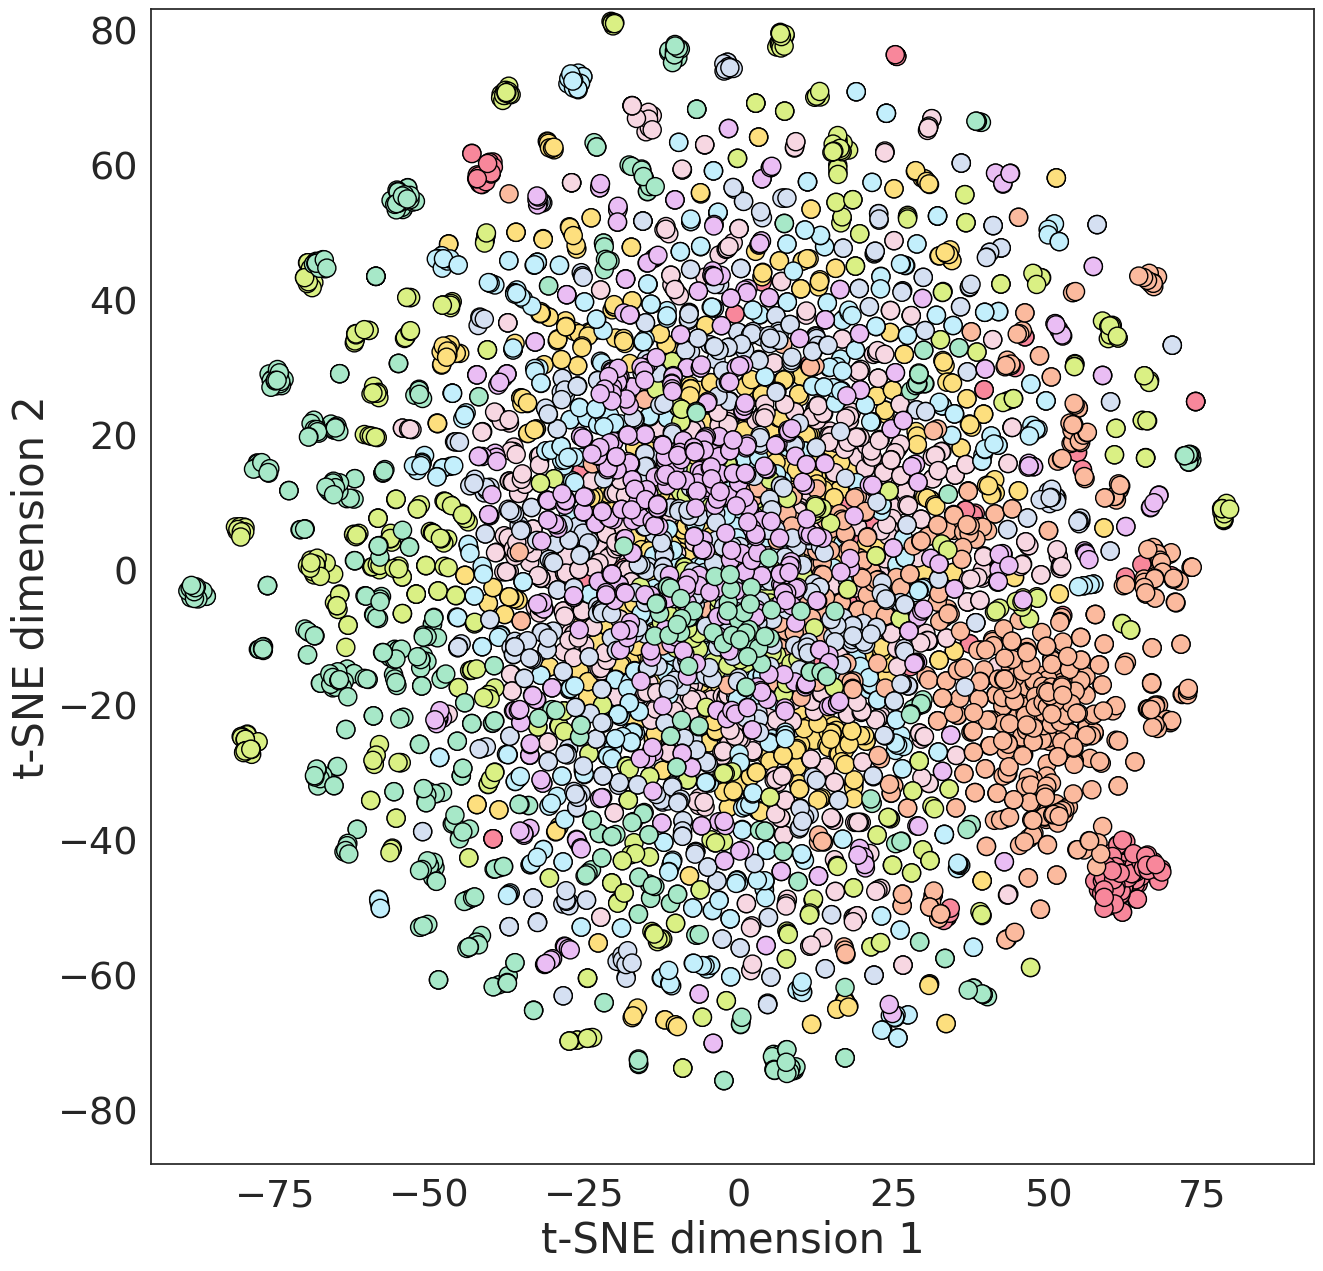

In [ ]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = tsne_dataset["dimension1"],
                y = tsne_dataset["dimension2"],
                hue = tsne_dataset["DATABASE"], #Label
                palette=['#F8879B', '#FDDF7E', '#F7D7E2', '#C3EFFC', '#FBBA9E', '#DAF084', '#D5E0F2', '#EABDF4', '#A7E8C8'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 83)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_ECFP4.png', bbox_inches = 'tight', dpi=400)

In [ ]:
#Select one database
DNMT1 = tsne_dataset[tsne_dataset["DATABASE"].str.contains("DNMT1")]
CDDNMT = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_CDDNMT")]
CDEPI = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_CDEPI")]
CDSOL = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_CDSOL")]
ABDNMT = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_DNMT1")]
FOODB = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_FOODB")]
LCDIV = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_LCDIV")]
LCEPI = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_LCEPI")]
UNPDA = tsne_dataset[tsne_dataset["DATABASE"].str.contains("AB_UNPDA")]

<Figure size 640x480 with 0 Axes>

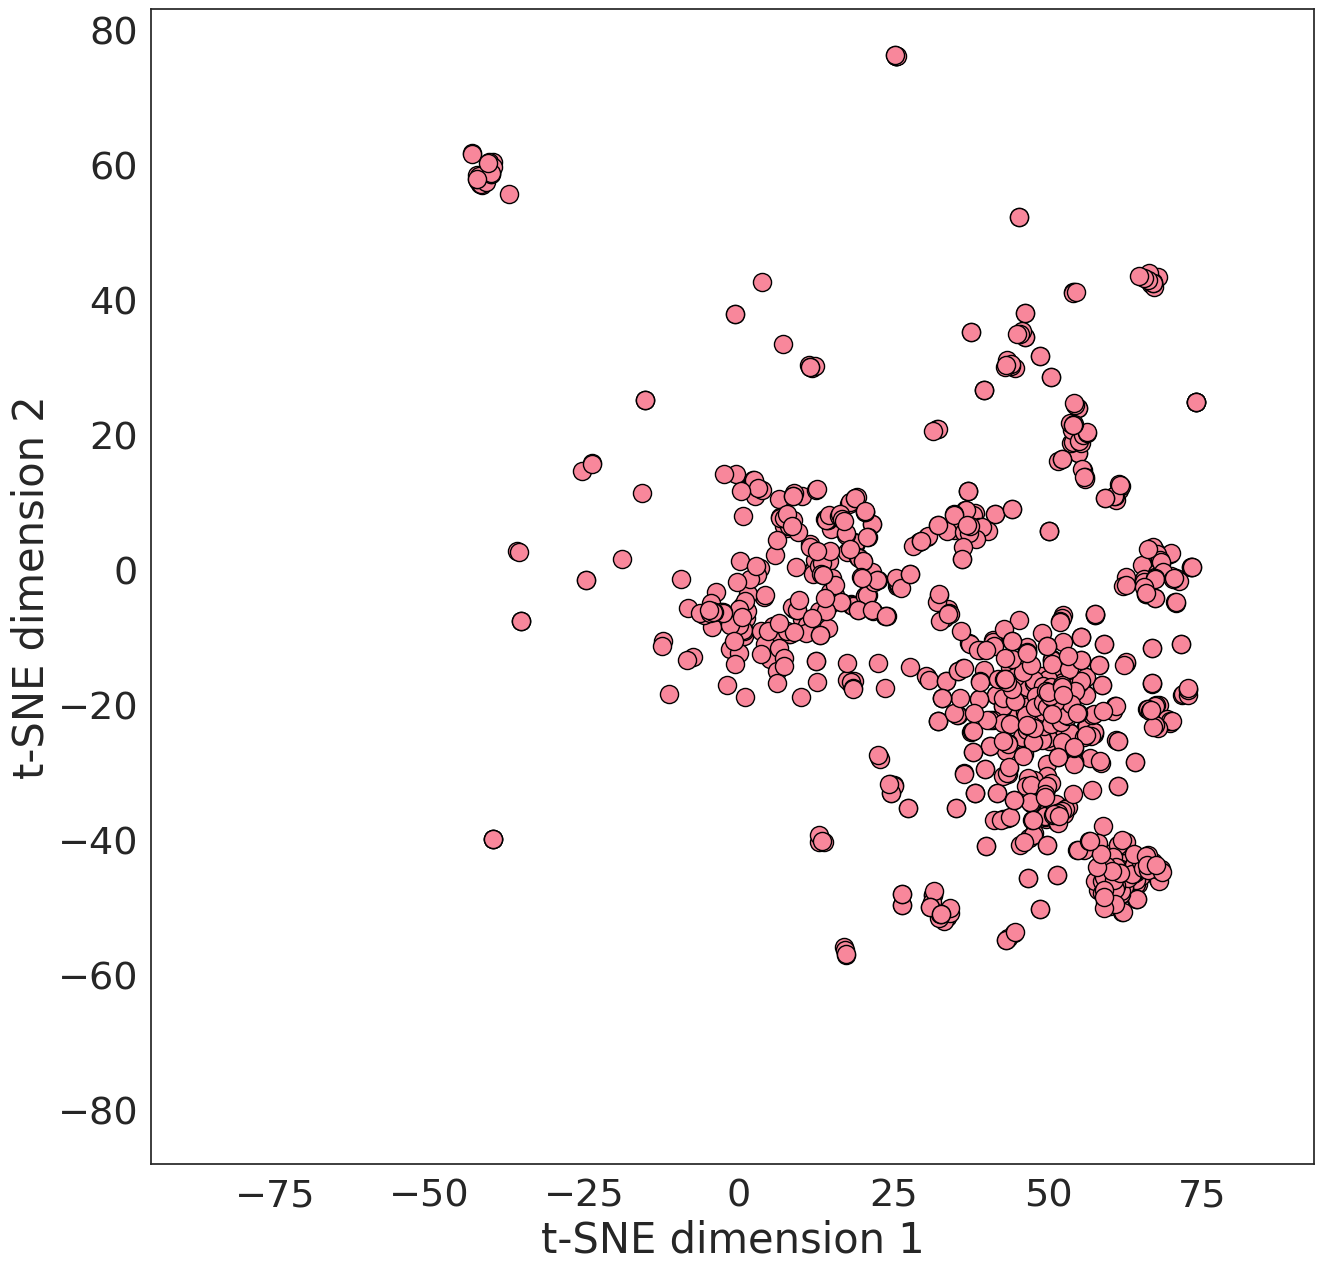

In [ ]:
#Visualization for each database
sns.set_style("white")

plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = DNMT1["dimension1"],
                y = DNMT1["dimension2"],
                color= '#F8879B',
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 83)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_ECFP4_1.png', bbox_inches = 'tight', dpi=400)

<Figure size 640x480 with 0 Axes>

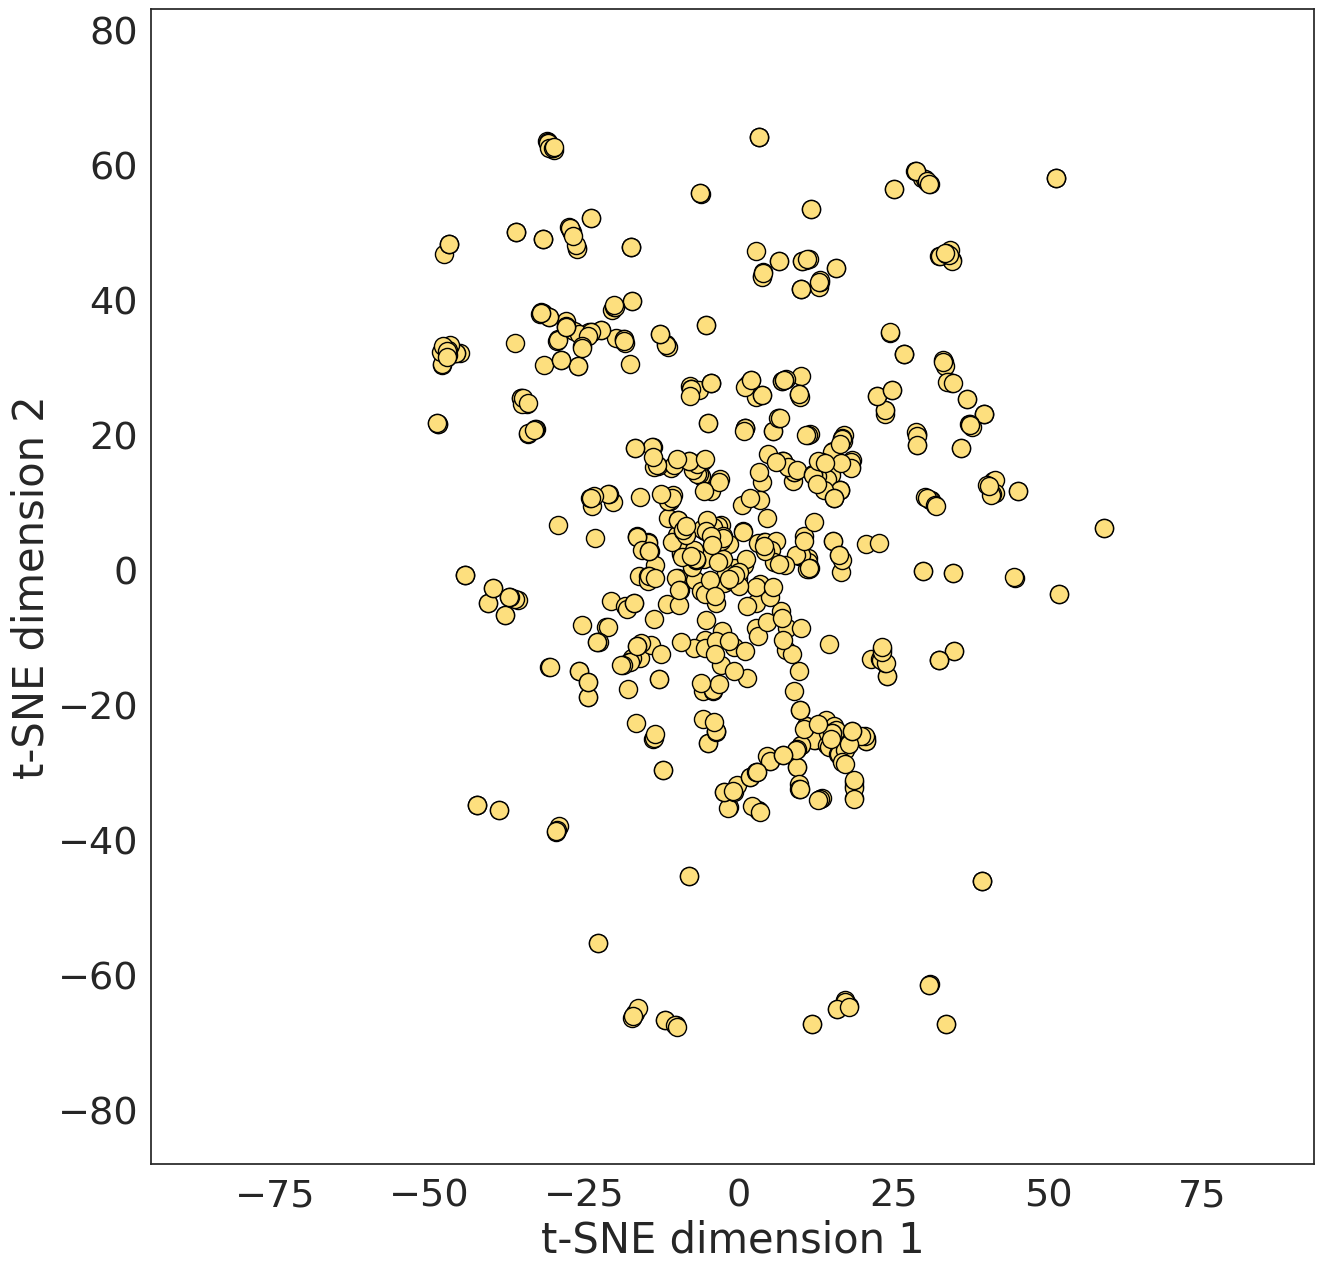

In [ ]:
#Visualization for each database
sns.set_style("white")

plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = CDDNMT["dimension1"],
                y = CDDNMT["dimension2"],
                color= '#FDDF7E',
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 83)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_ECFP4_2.png', bbox_inches = 'tight', dpi=400)

<Figure size 640x480 with 0 Axes>

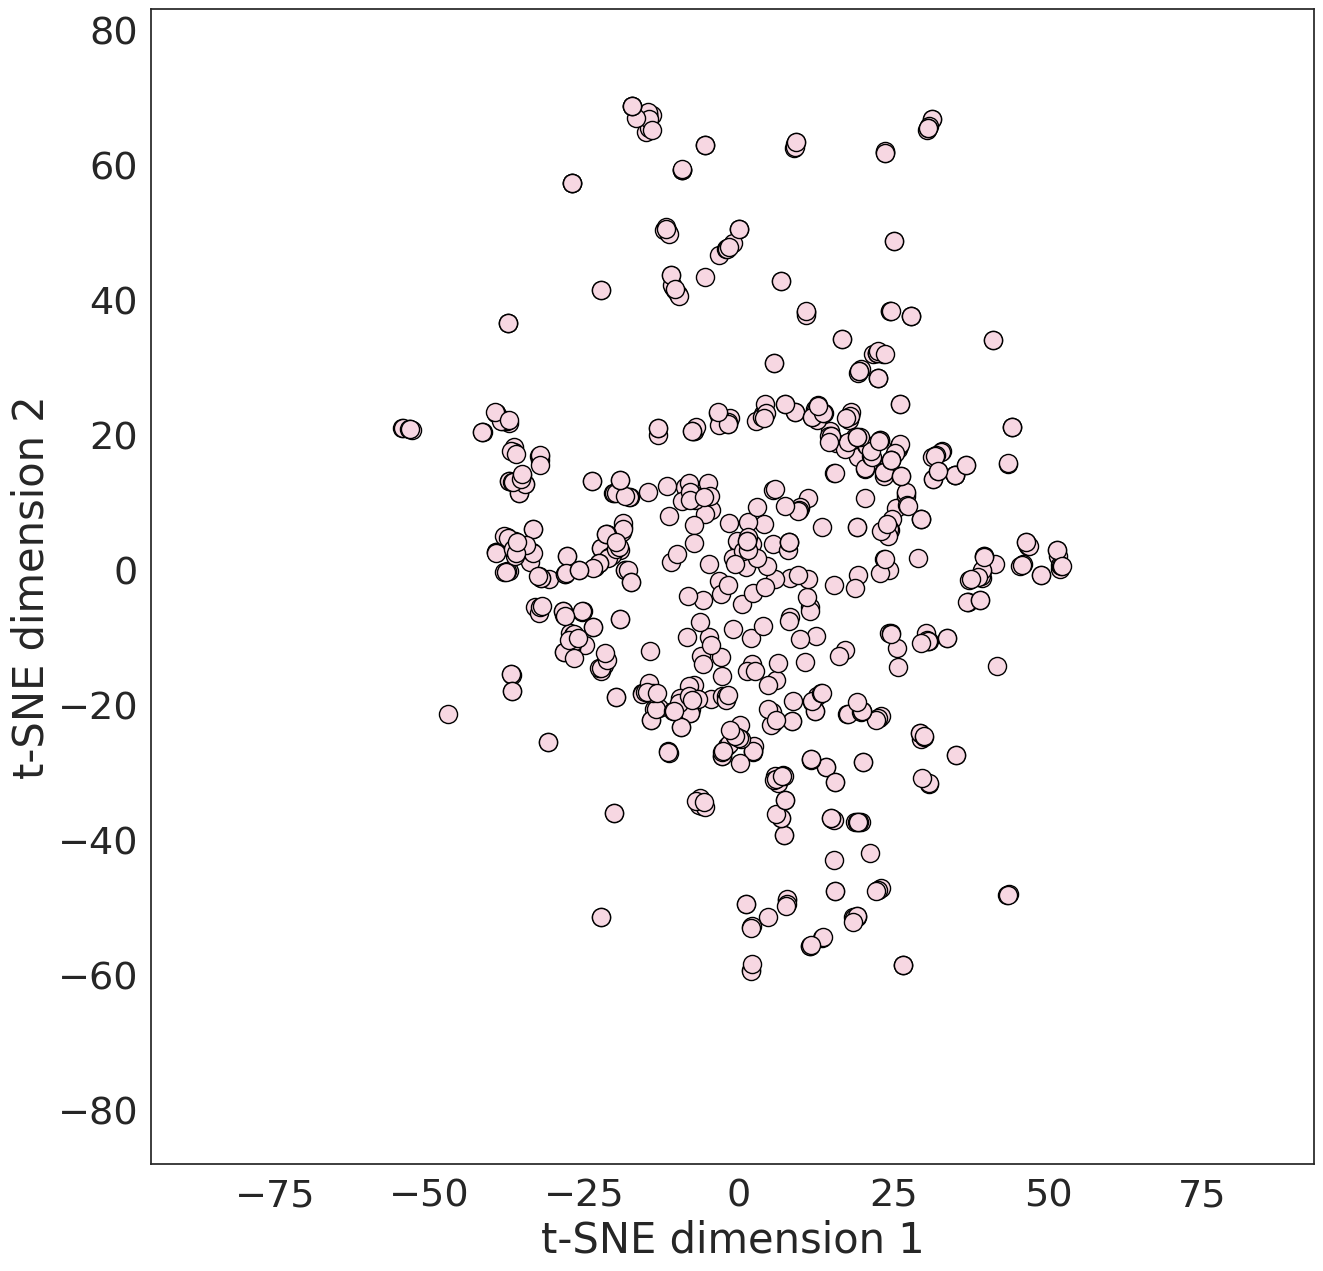

In [ ]:
#Visualization for each database
sns.set_style("white")

plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = CDEPI["dimension1"],
                y = CDEPI["dimension2"],
                color= '#F7D7E2',
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 83)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_ECFP4_3.png', bbox_inches = 'tight', dpi=400)

<Figure size 640x480 with 0 Axes>

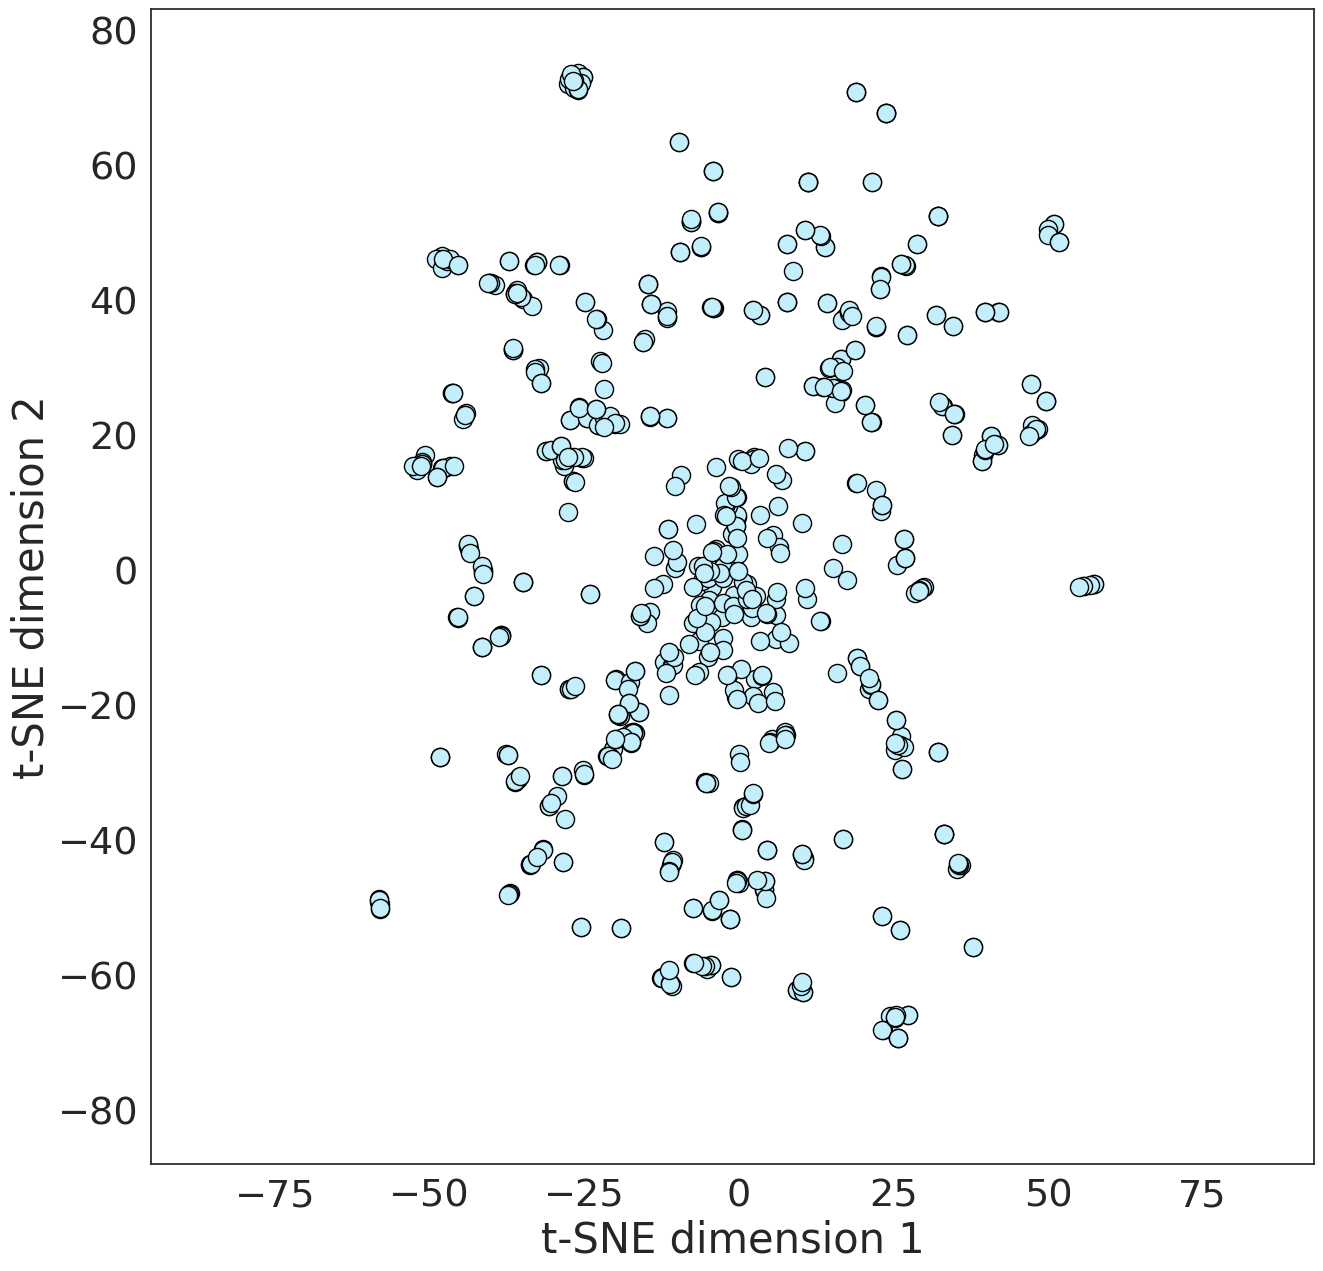

In [ ]:
#Visualization for each database
sns.set_style("white")

plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = CDSOL["dimension1"],
                y = CDSOL["dimension2"],
                color= '#C3EFFC',
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 83)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_ECFP4_4.png', bbox_inches = 'tight', dpi=400)

<Figure size 640x480 with 0 Axes>

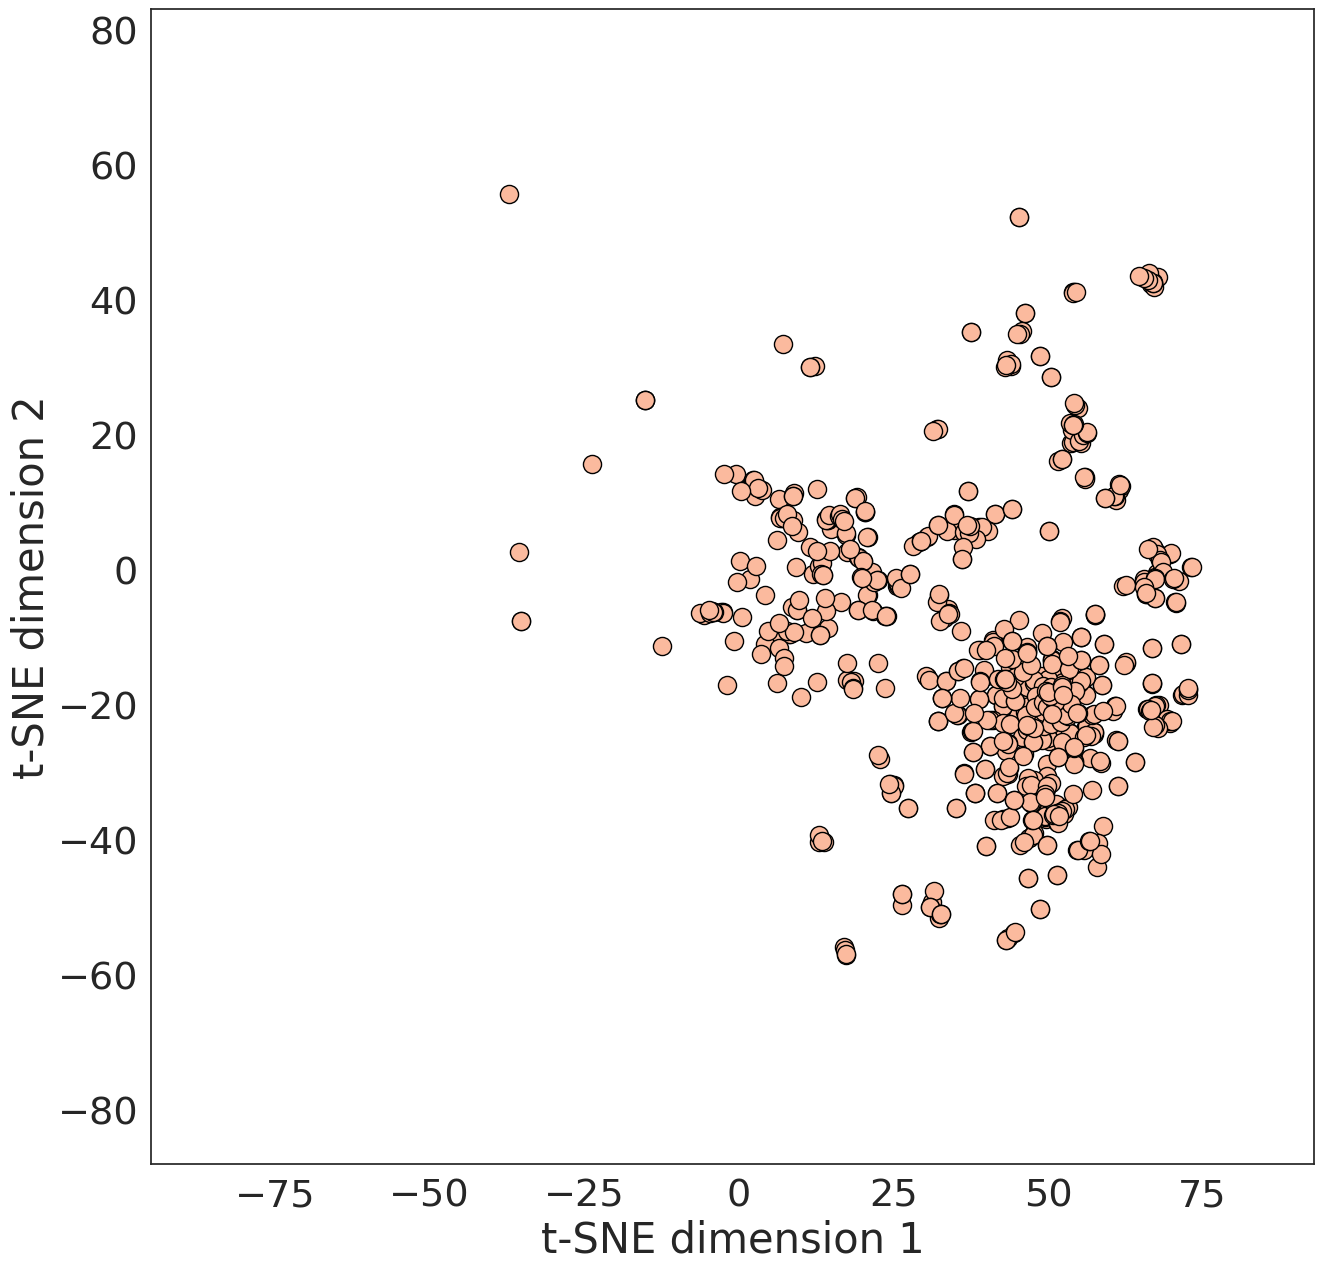

In [ ]:
#Visualization for each database
sns.set_style("white")

plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = ABDNMT["dimension1"],
                y = ABDNMT["dimension2"],
                color= '#FBBA9E',
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 83)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_ECFP4_5.png', bbox_inches = 'tight', dpi=400)

<Figure size 640x480 with 0 Axes>

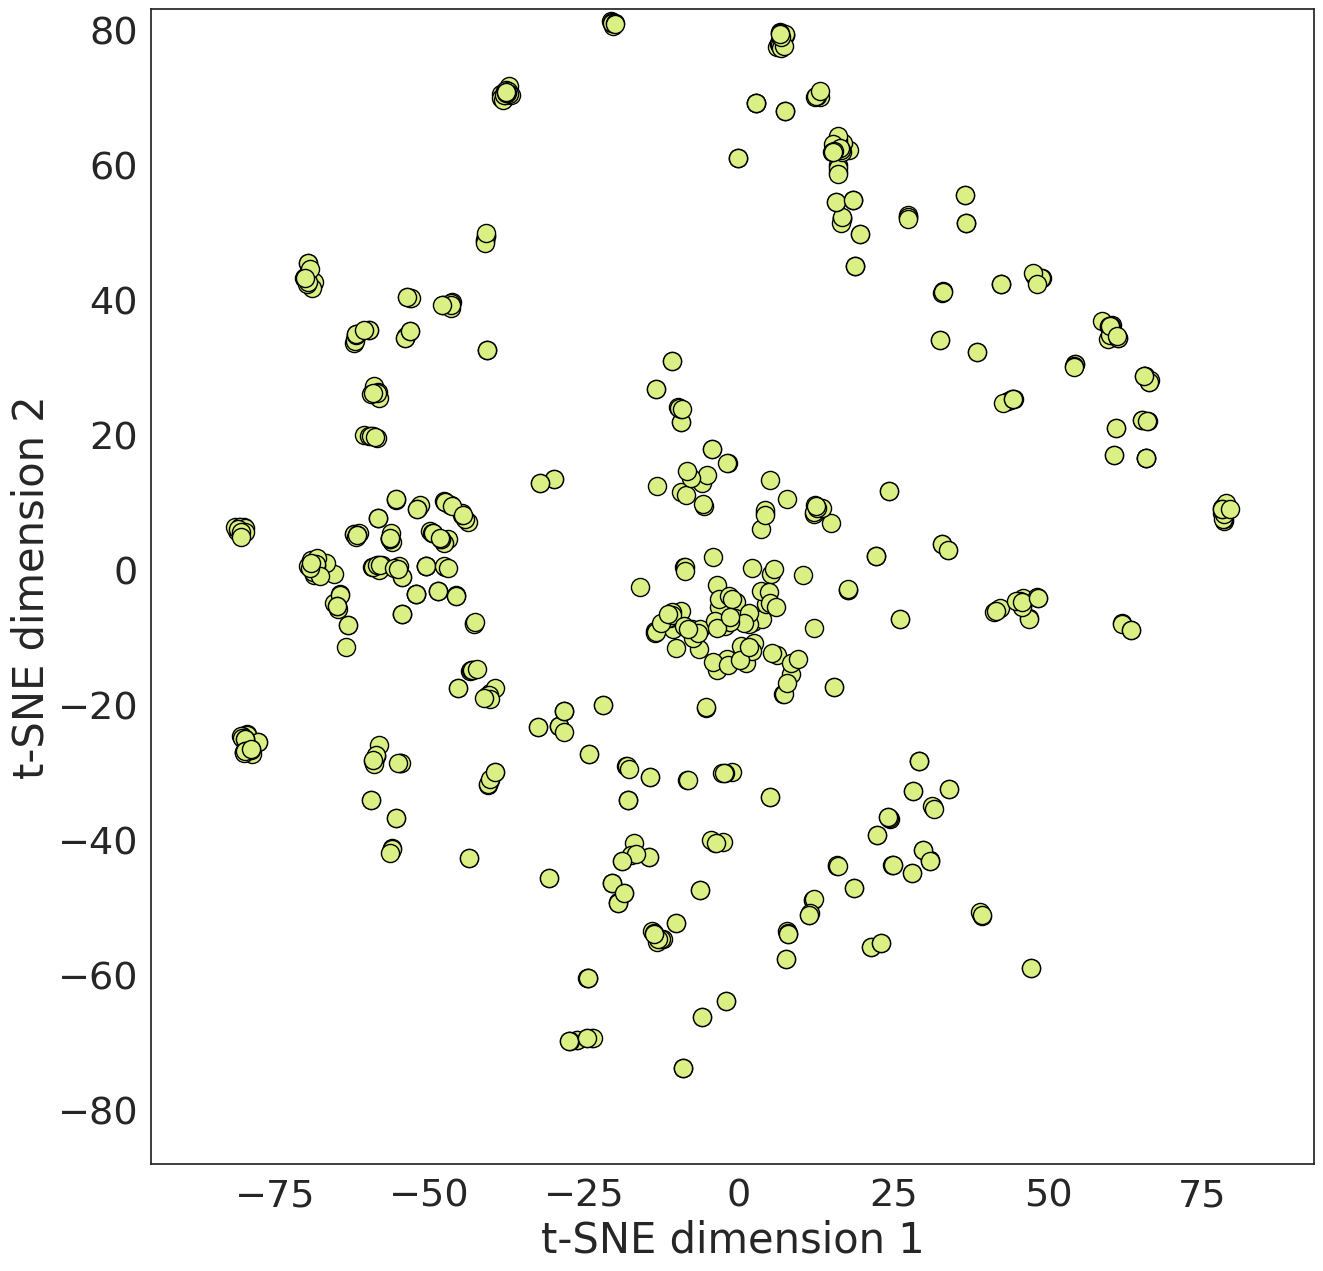

In [ ]:
#Visualization for each database
sns.set_style("white")

plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = FOODB["dimension1"],
                y = FOODB["dimension2"],
                color= '#DAF084',
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 83)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_ECFP4_6.png', bbox_inches = 'tight', dpi=400)

<Figure size 640x480 with 0 Axes>

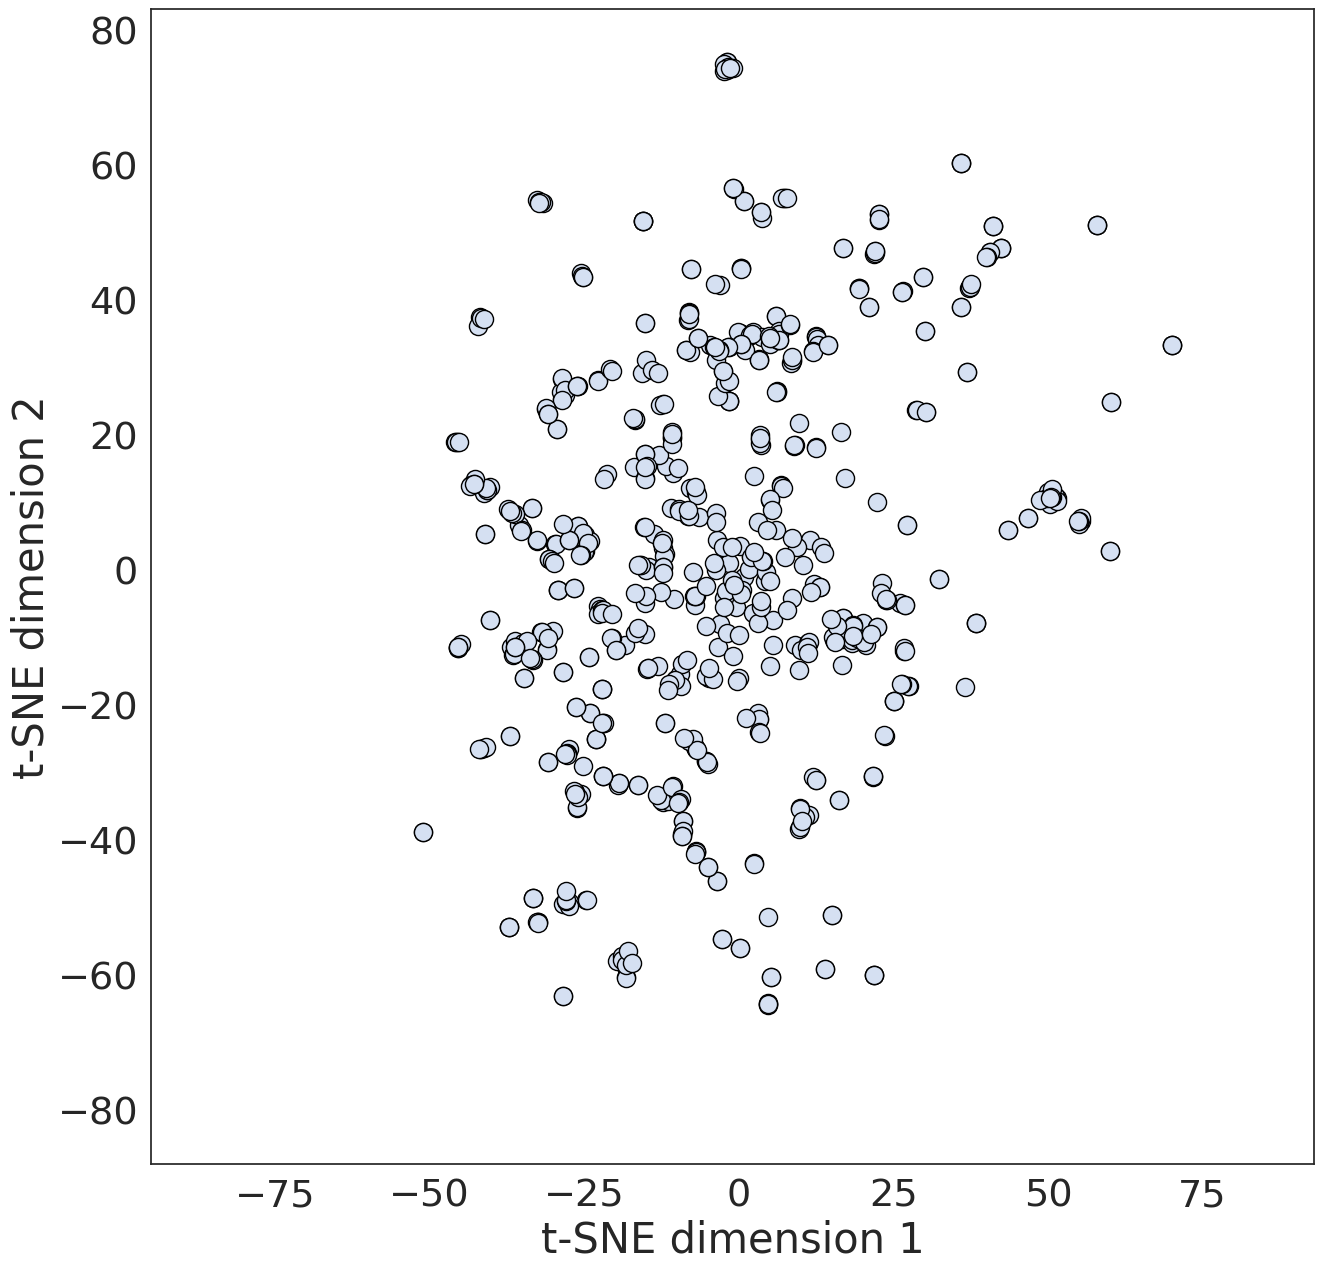

In [ ]:
#Visualization for each database
sns.set_style("white")

plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = LCDIV["dimension1"],
                y = LCDIV["dimension2"],
                color= '#D5E0F2',
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 83)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_ECFP4_7.png', bbox_inches = 'tight', dpi=400)

<Figure size 640x480 with 0 Axes>

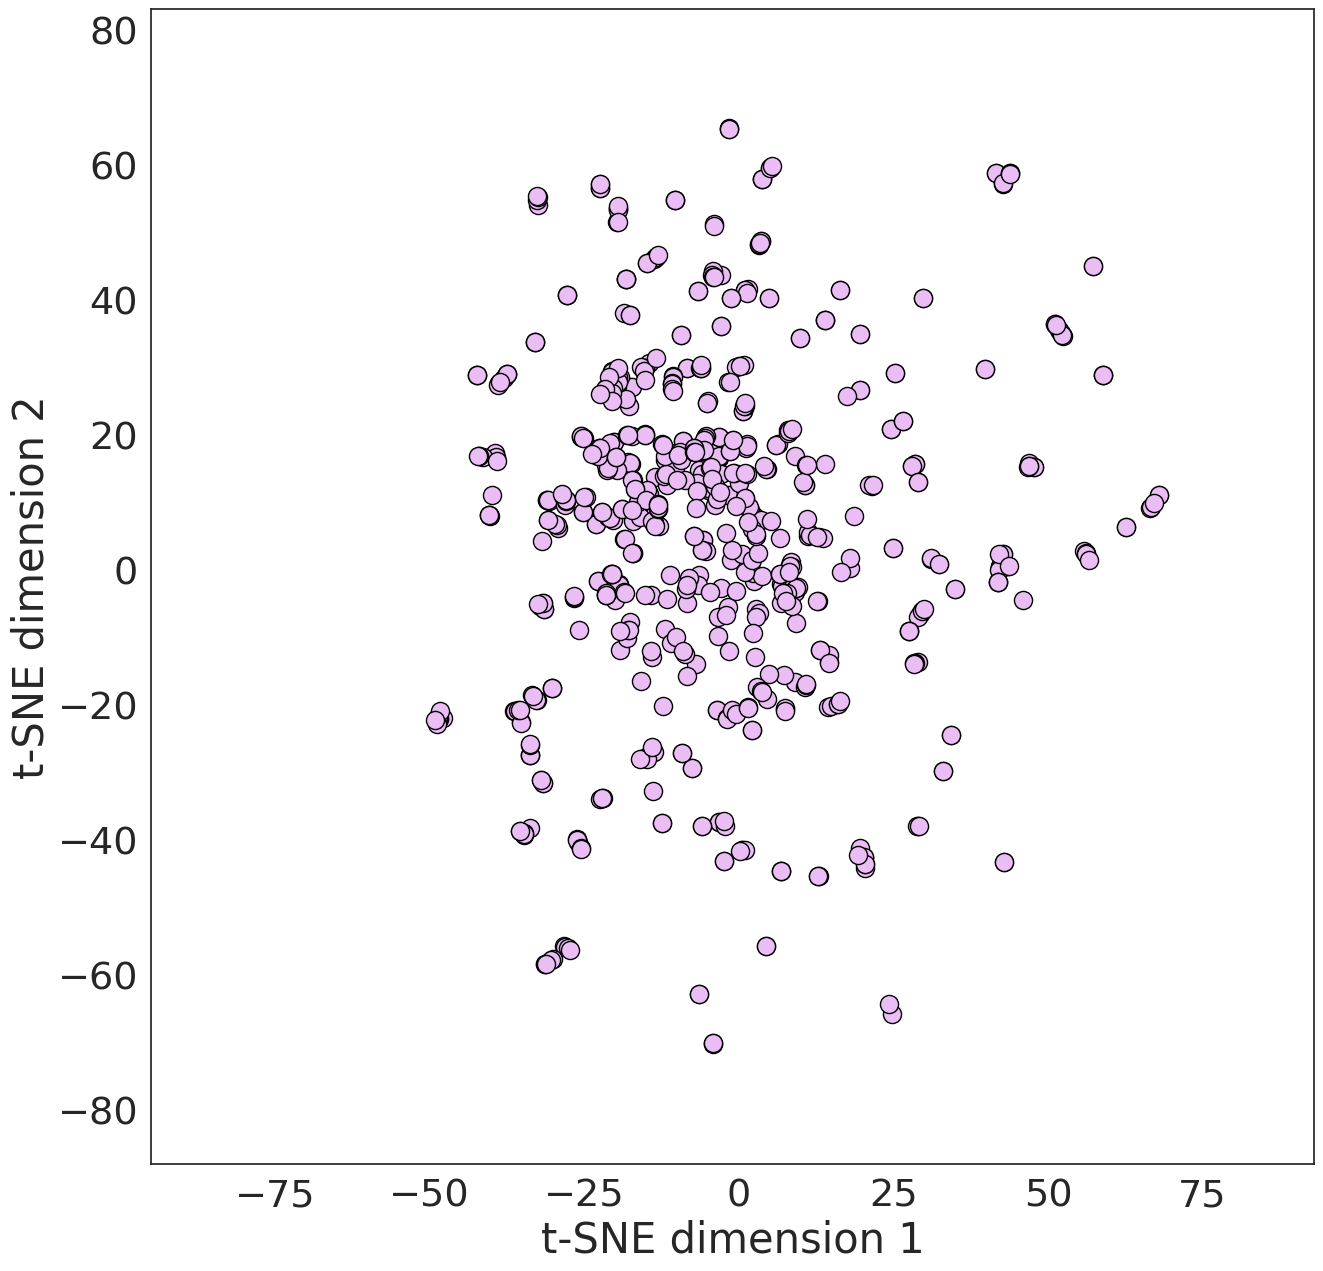

In [ ]:
#Visualization for each database
sns.set_style("white")

plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = LCEPI["dimension1"],
                y = LCEPI["dimension2"],
                color= '#EABDF4',
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 83)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_ECFP4_8.png', bbox_inches = 'tight', dpi=400)

<Figure size 640x480 with 0 Axes>

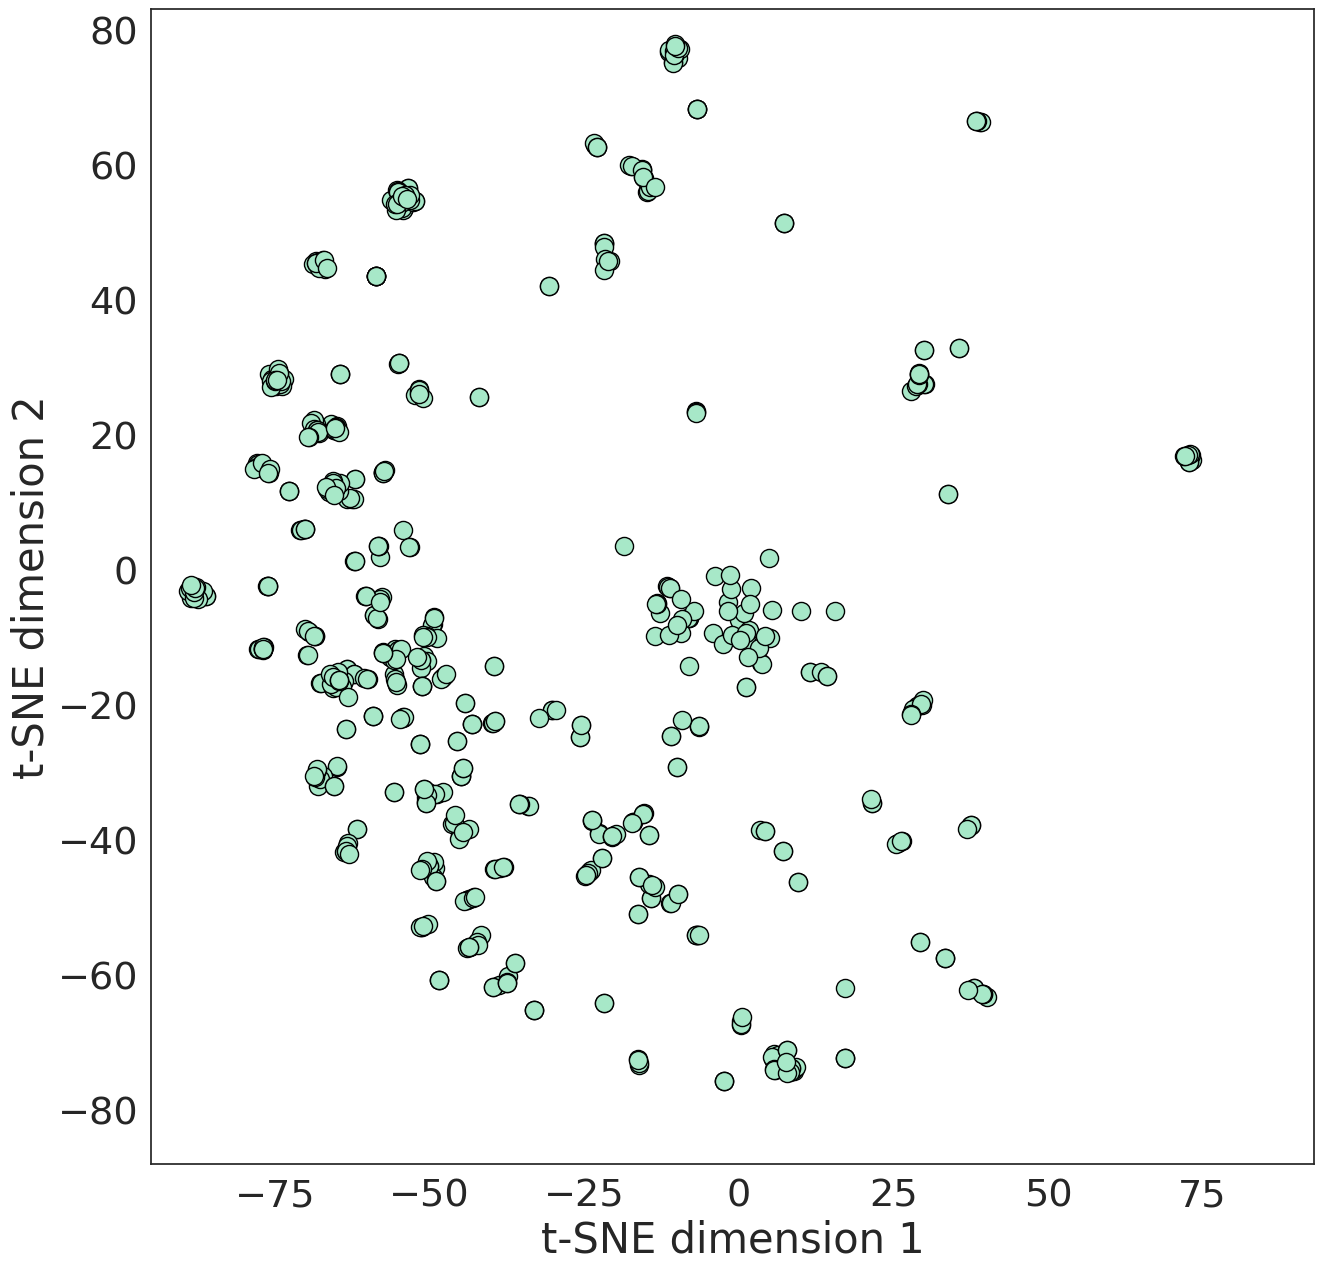

In [ ]:
#Visualization for each database
sns.set_style("white")

plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = UNPDA["dimension1"],
                y = UNPDA["dimension2"],
                color= '#A7E8C8',
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-95, 93)
ax.set_ylim(-88, 83)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_ECFP4_9.png', bbox_inches = 'tight', dpi=400)

In [ ]:
#MACCS Keys
df_MACCS_Keys=pd.DataFrame([[int(y) for y in MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)).ToBitString()] for x in DATA["SMILES"]])

In [ ]:
data_tsne_2 = df_MACCS_Keys.copy()
data_tsne_2 = StandardScaler().fit_transform(data_tsne_2)
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne_results_2 = tsne.fit_transform(data_tsne_2)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5860 samples in 0.004s...
[t-SNE] Computed neighbors for 5860 samples in 0.872s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5860
[t-SNE] Computed conditional probabilities for sample 2000 / 5860
[t-SNE] Computed conditional probabilities for sample 3000 / 5860
[t-SNE] Computed conditional probabilities for sample 4000 / 5860
[t-SNE] Computed conditional probabilities for sample 5000 / 5860
[t-SNE] Computed conditional probabilities for sample 5860 / 5860
[t-SNE] Mean sigma: 4.161596
[t-SNE] KL divergence after 250 iterations with early exaggeration: 83.336479
[t-SNE] KL divergence after 1000 iterations: 1.769960


In [ ]:
label = DATA[["DATABASE", "ID", 'SMILES',]]
label = label.to_numpy()
arr_2 = np.concatenate((label, tsne_results_2), axis = 1)

In [ ]:
# New dataframe
tsne_dataset_2 = pd.DataFrame(data=arr_2, columns=["DATABASE", "ID", "SMILES",'dimension1', 'dimension2'] )
tsne_dataset_2.head(2)

DATABASE             ID                                             SMILES  \
0    DNMT1  CHEMBL3087498  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cc...   
1    DNMT1  CHEMBL2171169  CC(C)N(CCCNC(=O)Nc1ccc(C(C)(C)C)cc1)CC1OC(n2cn...   

  dimension1 dimension2  
0 -12.656156  -5.370169  
1 -12.650945  -5.356319

<Figure size 640x480 with 0 Axes>

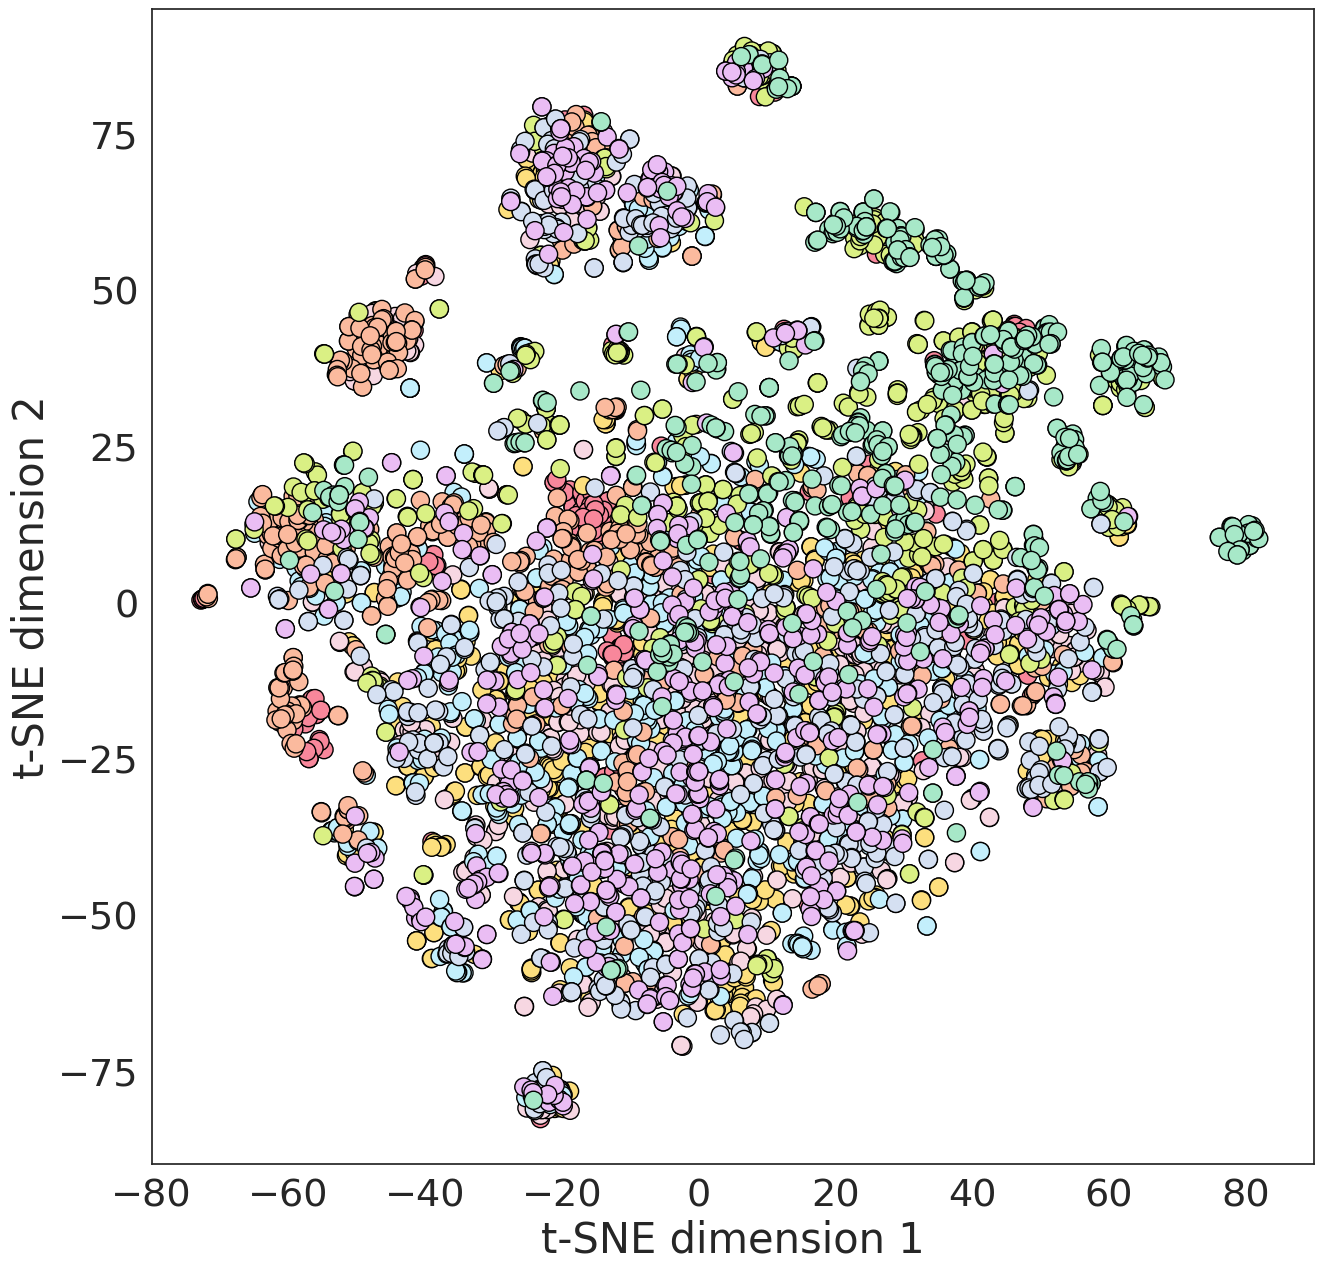

In [ ]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = tsne_dataset_2["dimension1"],
                y = tsne_dataset_2["dimension2"],
                hue = tsne_dataset_2["DATABASE"], #Label
                palette=['#F8879B', '#FDDF7E', '#F7D7E2', '#C3EFFC', '#FBBA9E', '#DAF084', '#D5E0F2', '#EABDF4', '#A7E8C8'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-80, 90)
ax.set_ylim(-90, 95)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_MACCS.png', bbox_inches = 'tight', dpi=400)

In [ ]:
#Select one database
DNMT1 = tsne_dataset_2[tsne_dataset_2["DATABASE"].str.contains("DNMT1")]
CDDNMT = tsne_dataset_2[tsne_dataset_2["DATABASE"].str.contains("AB_CDDNMT")]
CDEPI = tsne_dataset_2[tsne_dataset_2["DATABASE"].str.contains("AB_CDEPI")]
CDSOL = tsne_dataset_2[tsne_dataset_2["DATABASE"].str.contains("AB_CDSOL")]
ABDNMT = tsne_dataset_2[tsne_dataset_2["DATABASE"].str.contains("AB_DNMT1")]
FOODB = tsne_dataset_2[tsne_dataset_2["DATABASE"].str.contains("AB_FOODB")]
LCDIV = tsne_dataset_2[tsne_dataset_2["DATABASE"].str.contains("AB_LCDIV")]
LCEPI = tsne_dataset_2[tsne_dataset_2["DATABASE"].str.contains("AB_LCEPI")]
UNPDA = tsne_dataset_2[tsne_dataset_2["DATABASE"].str.contains("AB_UNPDA")]

<Figure size 640x480 with 0 Axes>

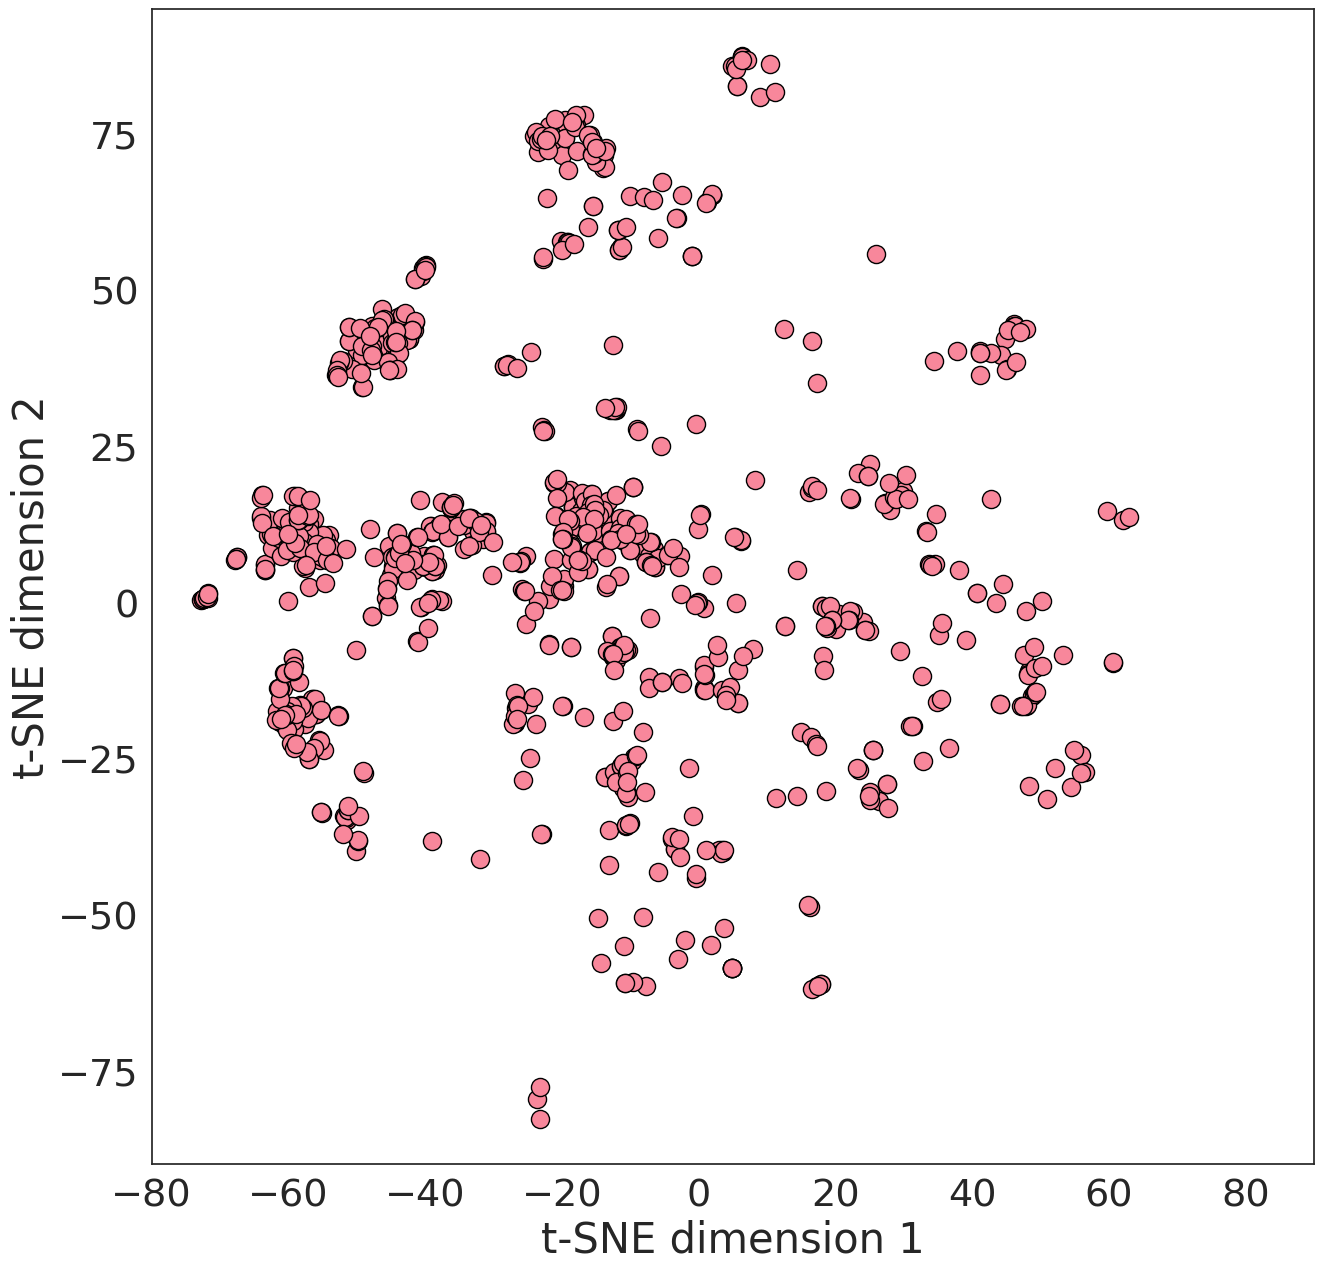

In [ ]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = DNMT1["dimension1"],
                y = DNMT1["dimension2"],
                color=['#F8879B'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-80, 90)
ax.set_ylim(-90, 95)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_MACCS_1.png', bbox_inches='tight', dpi=400)

<Figure size 640x480 with 0 Axes>

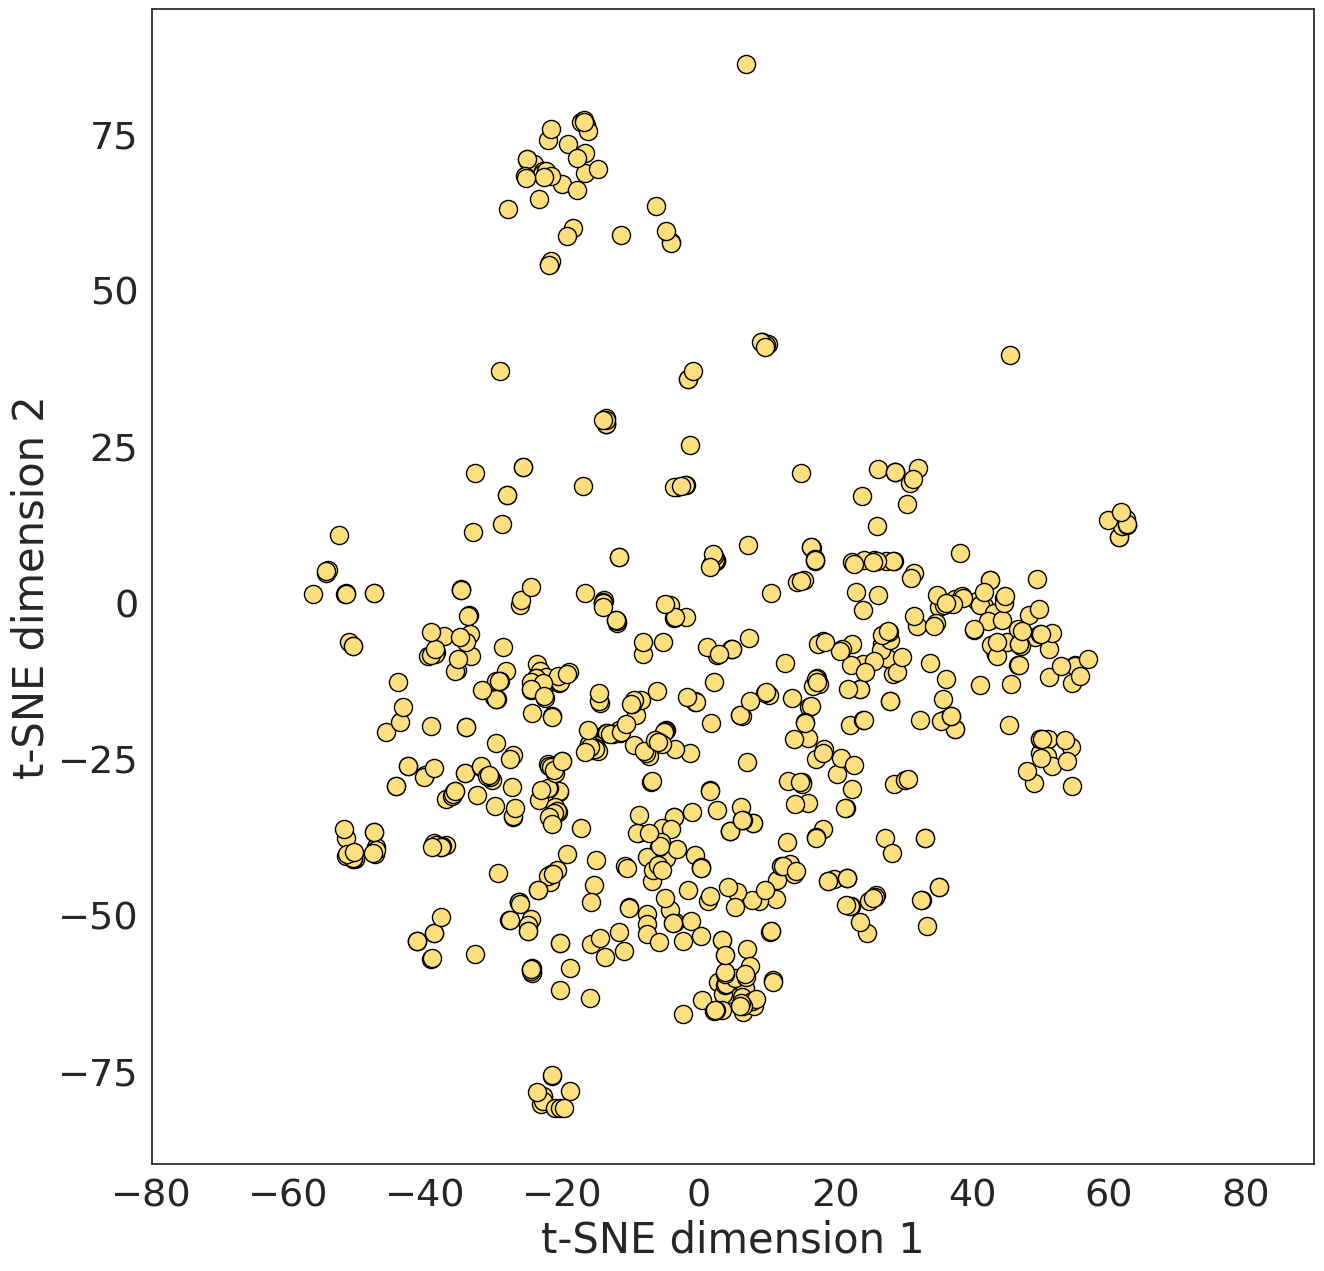

In [ ]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = CDDNMT["dimension1"],
                y = CDDNMT["dimension2"],
                color=['#FDDF7E'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-80, 90)
ax.set_ylim(-90, 95)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_MACCS_2.png', bbox_inches='tight', dpi=400)

<Figure size 640x480 with 0 Axes>

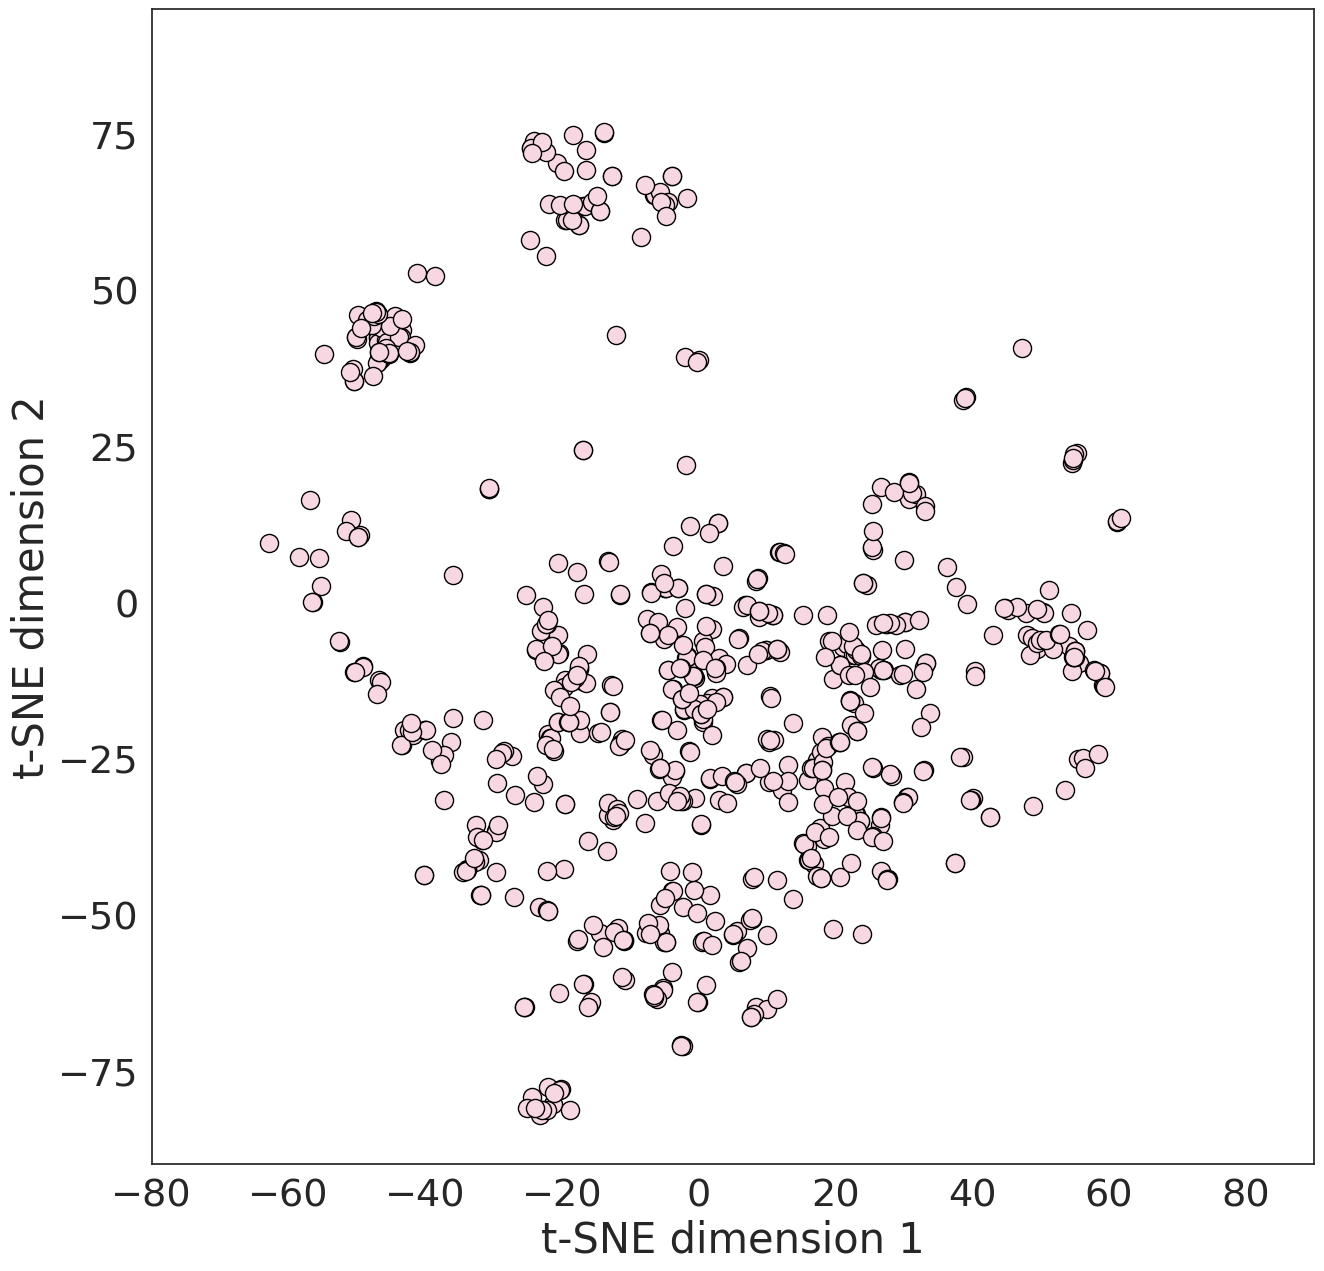

In [ ]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = CDEPI["dimension1"],
                y = CDEPI["dimension2"],
                color=['#F7D7E2'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-80, 90)
ax.set_ylim(-90, 95)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_MACCS_3.png', bbox_inches='tight', dpi=400)


<Figure size 640x480 with 0 Axes>

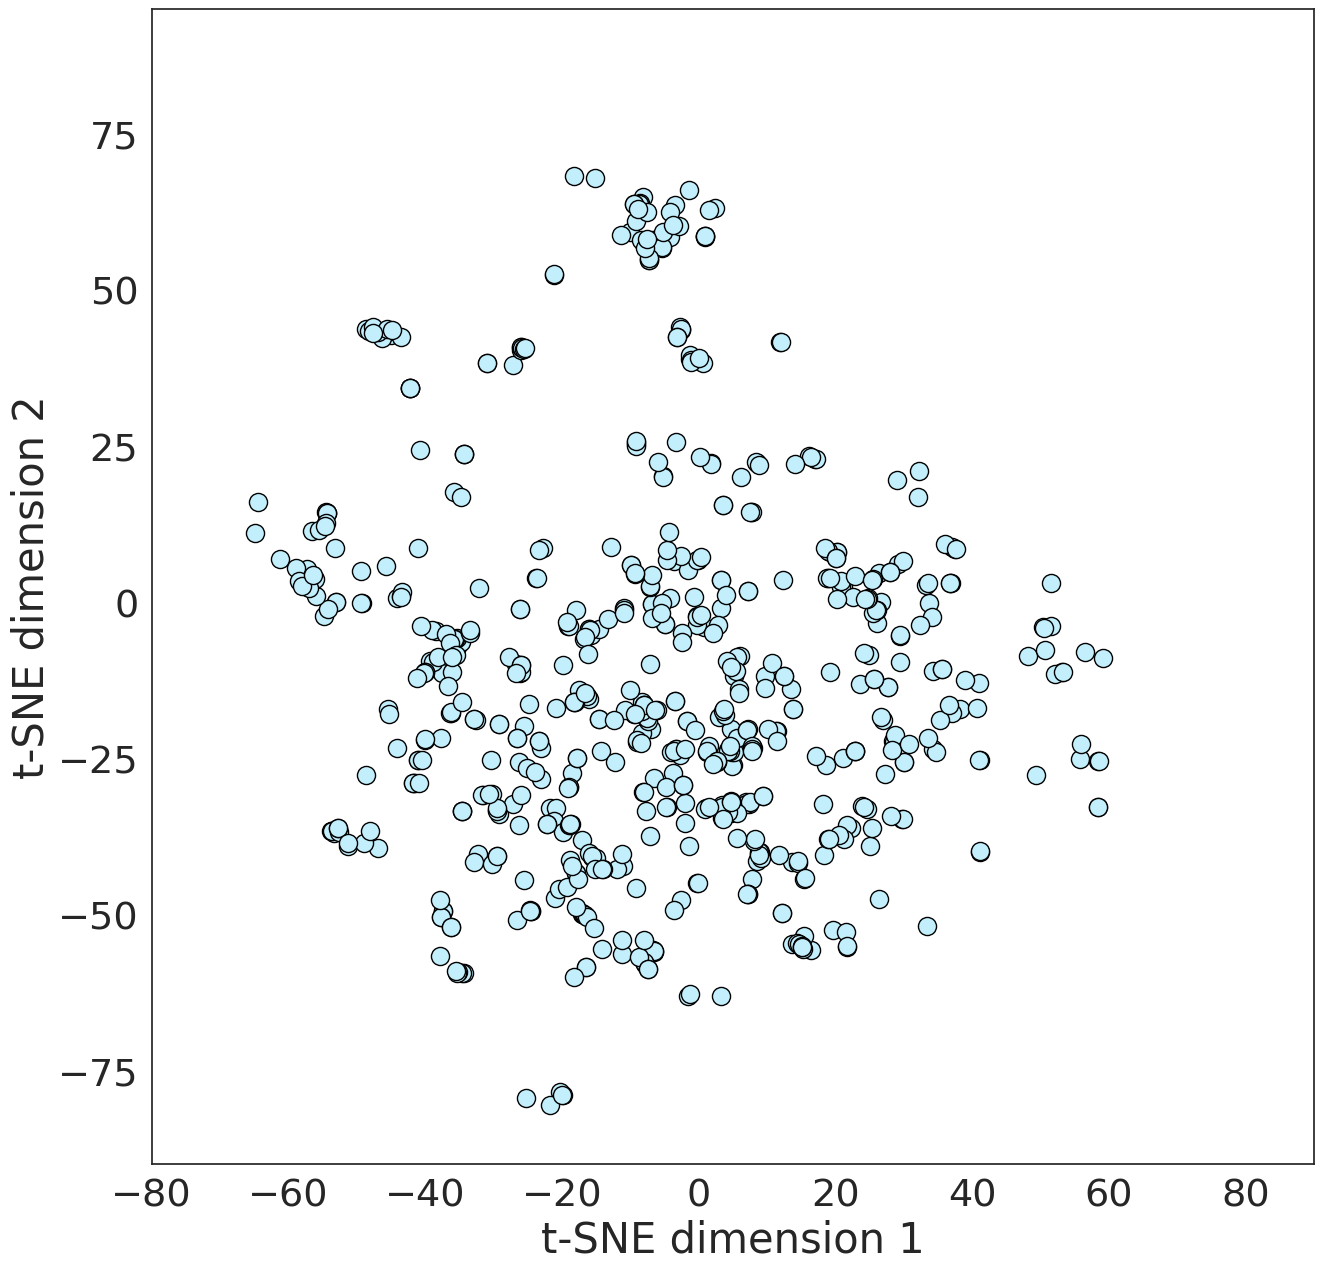

In [ ]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = CDSOL["dimension1"],
                y = CDSOL["dimension2"],
                color=['#C3EFFC'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-80, 90)
ax.set_ylim(-90, 95)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_MACCS_4.png', bbox_inches='tight', dpi=400)

<Figure size 640x480 with 0 Axes>

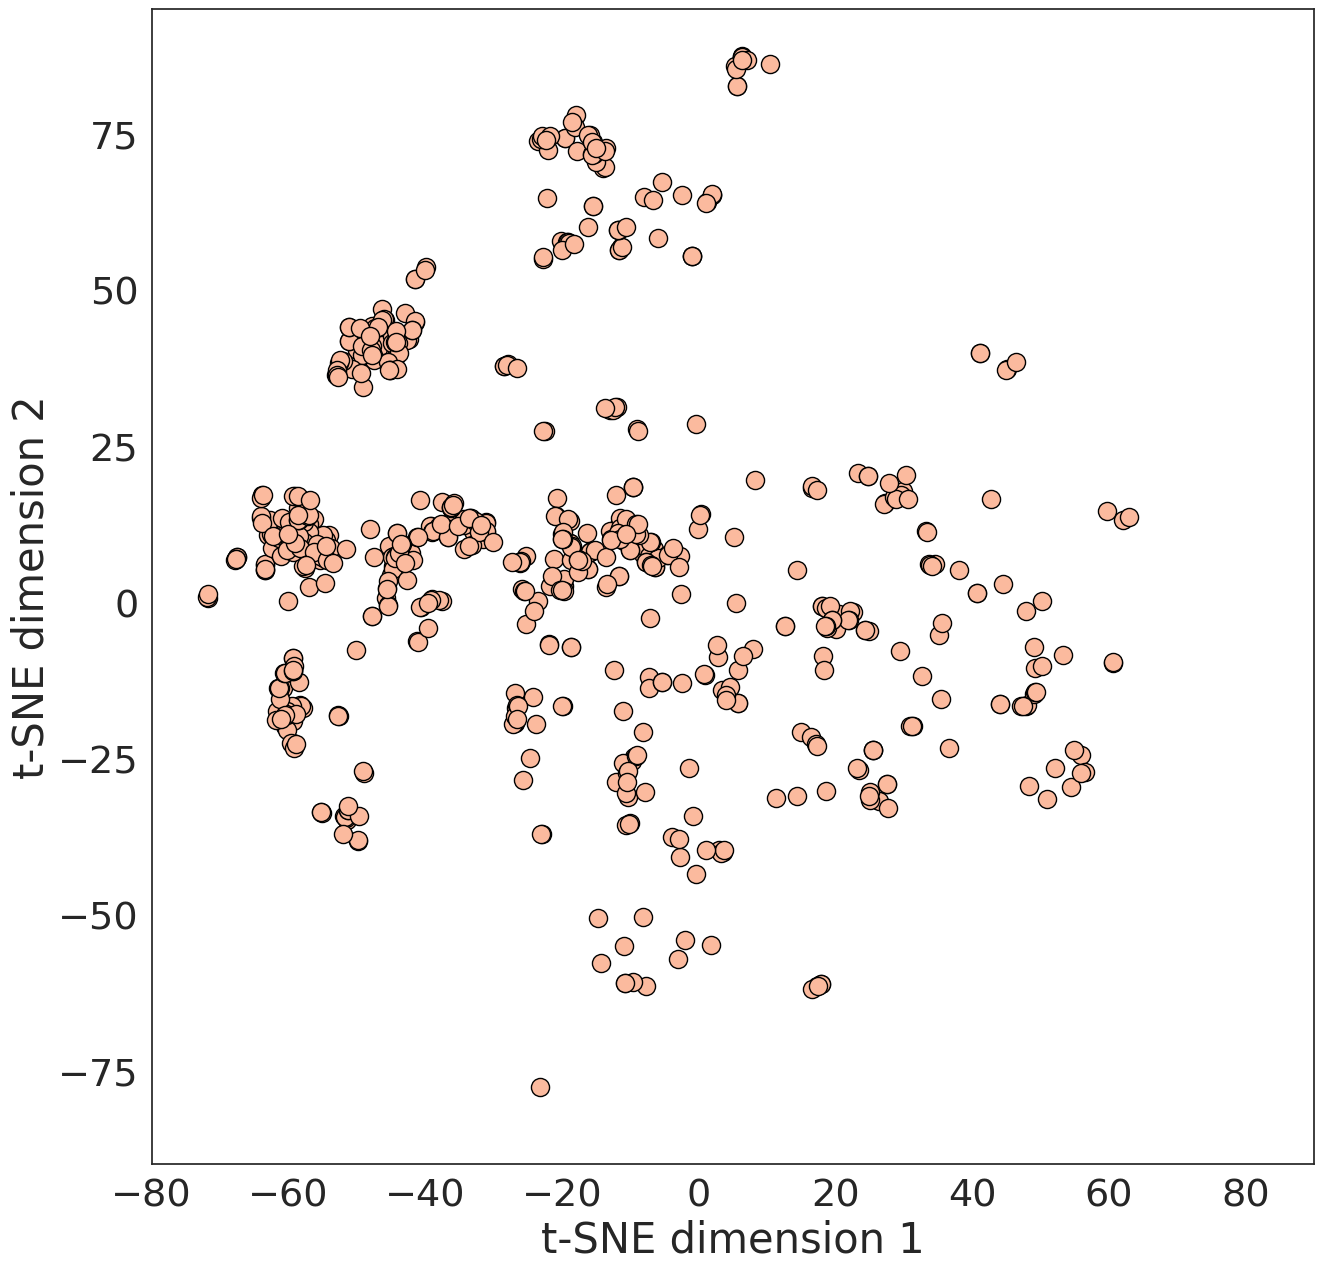

In [ ]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = ABDNMT["dimension1"],
                y = ABDNMT["dimension2"],
                color=['#FBBA9E'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-80, 90)
ax.set_ylim(-90, 95)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_MACCS_5.png', bbox_inches='tight', dpi=400)


<Figure size 640x480 with 0 Axes>

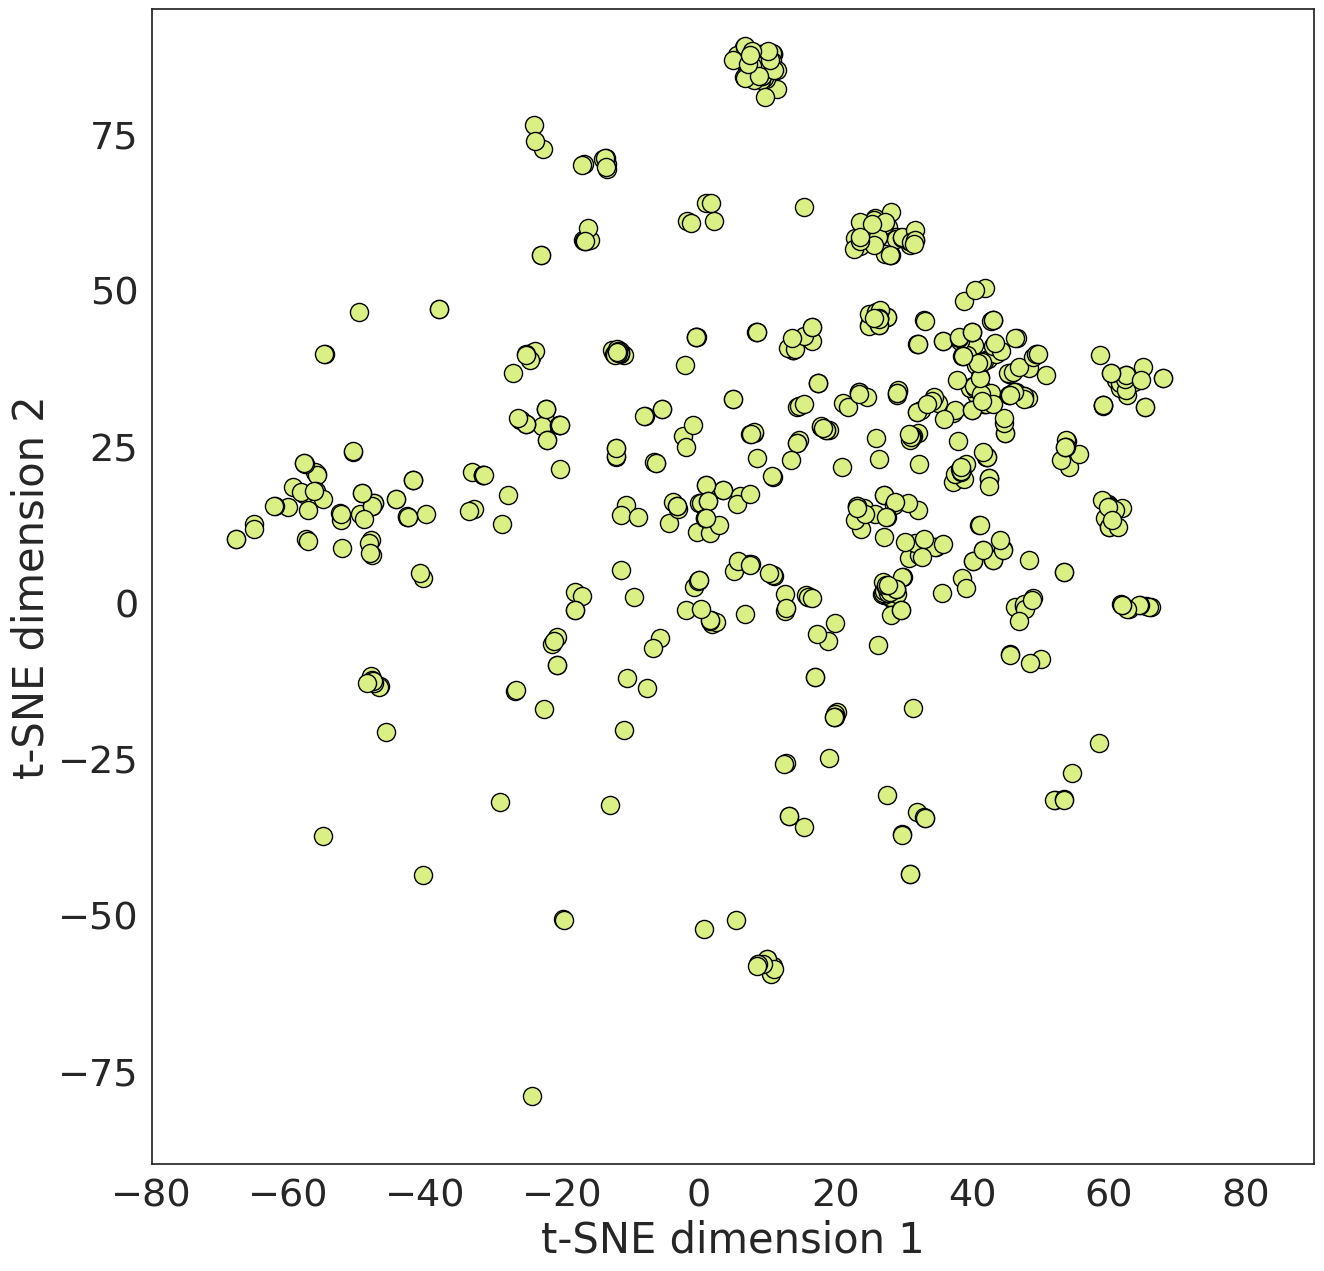

In [ ]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = FOODB["dimension1"],
                y = FOODB["dimension2"],
                color=['#DAF084'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-80, 90)
ax.set_ylim(-90, 95)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_MACCS_6.png', bbox_inches='tight', dpi=400)

<Figure size 640x480 with 0 Axes>

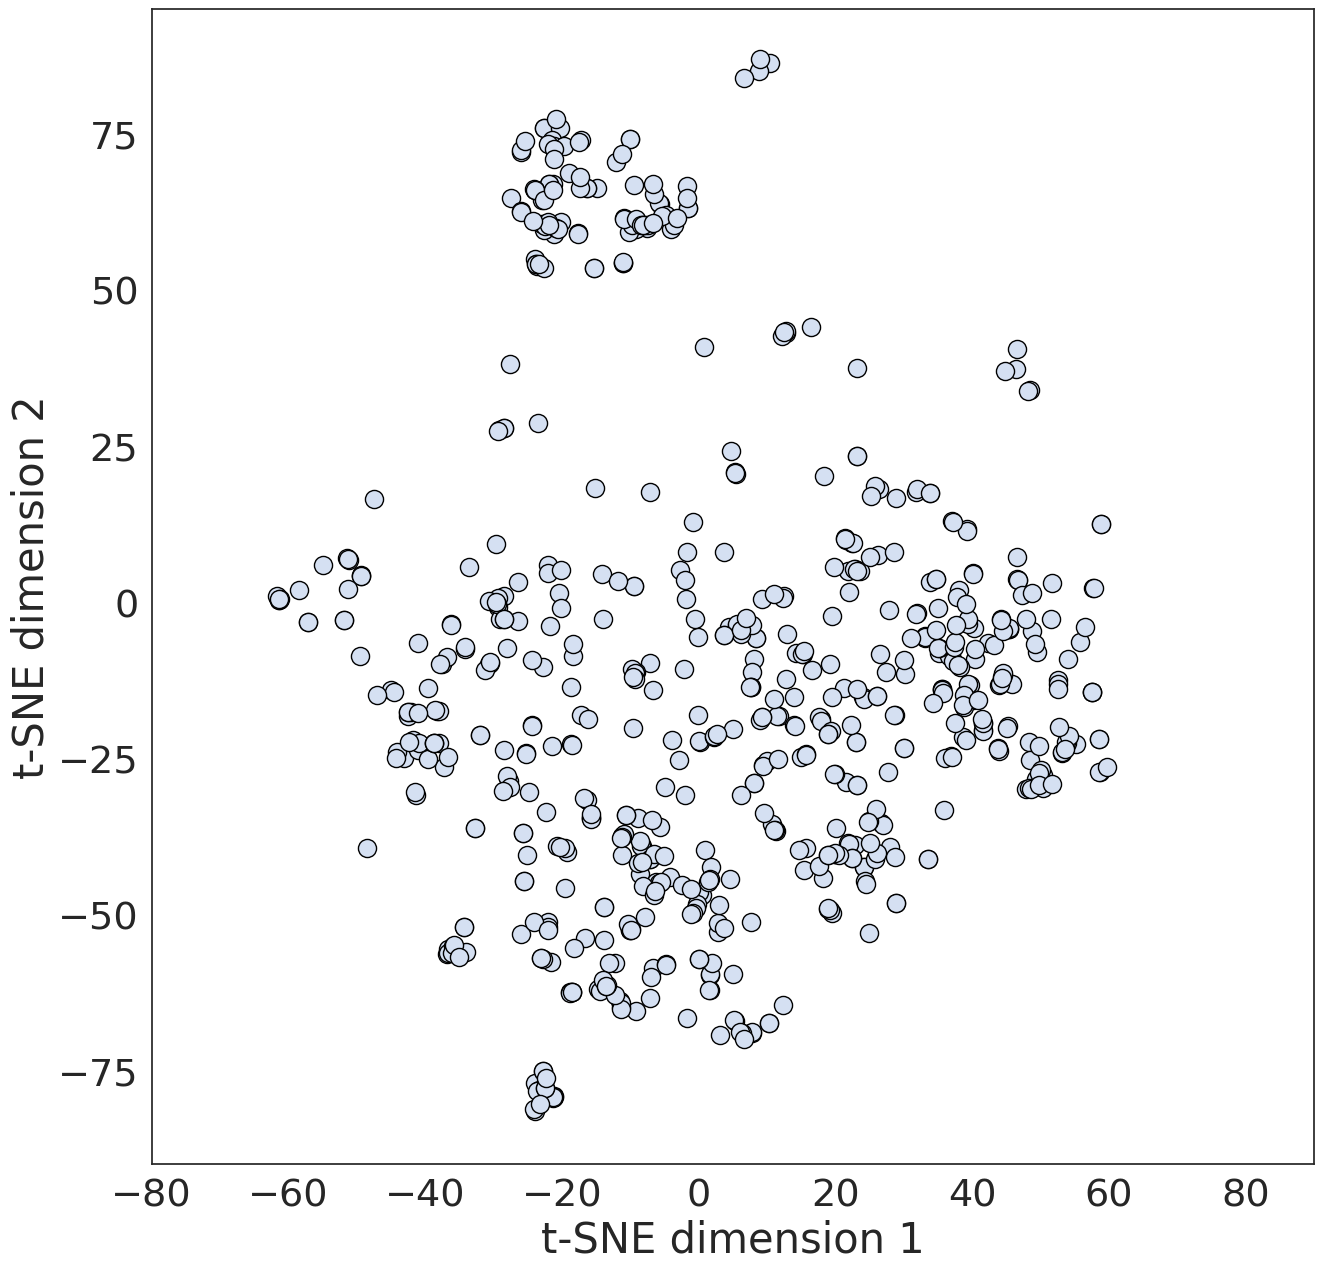

In [ ]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = LCDIV["dimension1"],
                y = LCDIV["dimension2"],
                color=['#D5E0F2'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-80, 90)
ax.set_ylim(-90, 95)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_MACCS_7.png', bbox_inches='tight', dpi=400)

<Figure size 640x480 with 0 Axes>

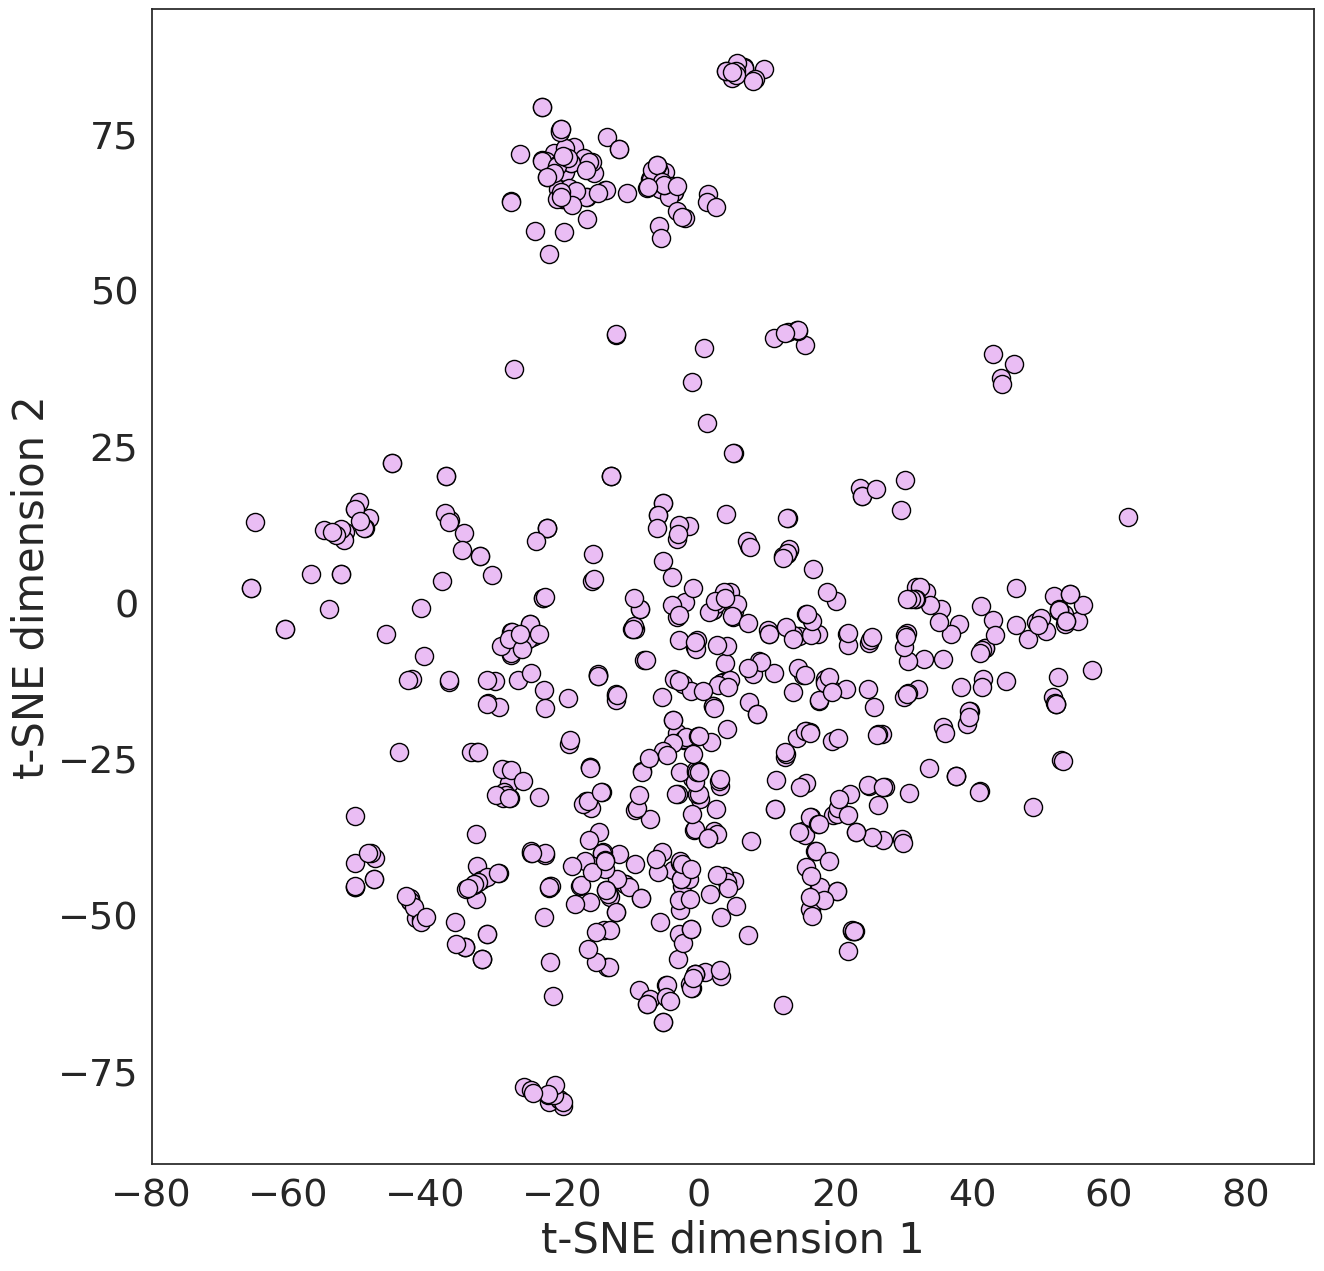

In [ ]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = LCEPI["dimension1"],
                y = LCEPI["dimension2"],
                color=['#EABDF4'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-80, 90)
ax.set_ylim(-90, 95)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_MACCS_8.png', bbox_inches='tight', dpi=400)

<Figure size 640x480 with 0 Axes>

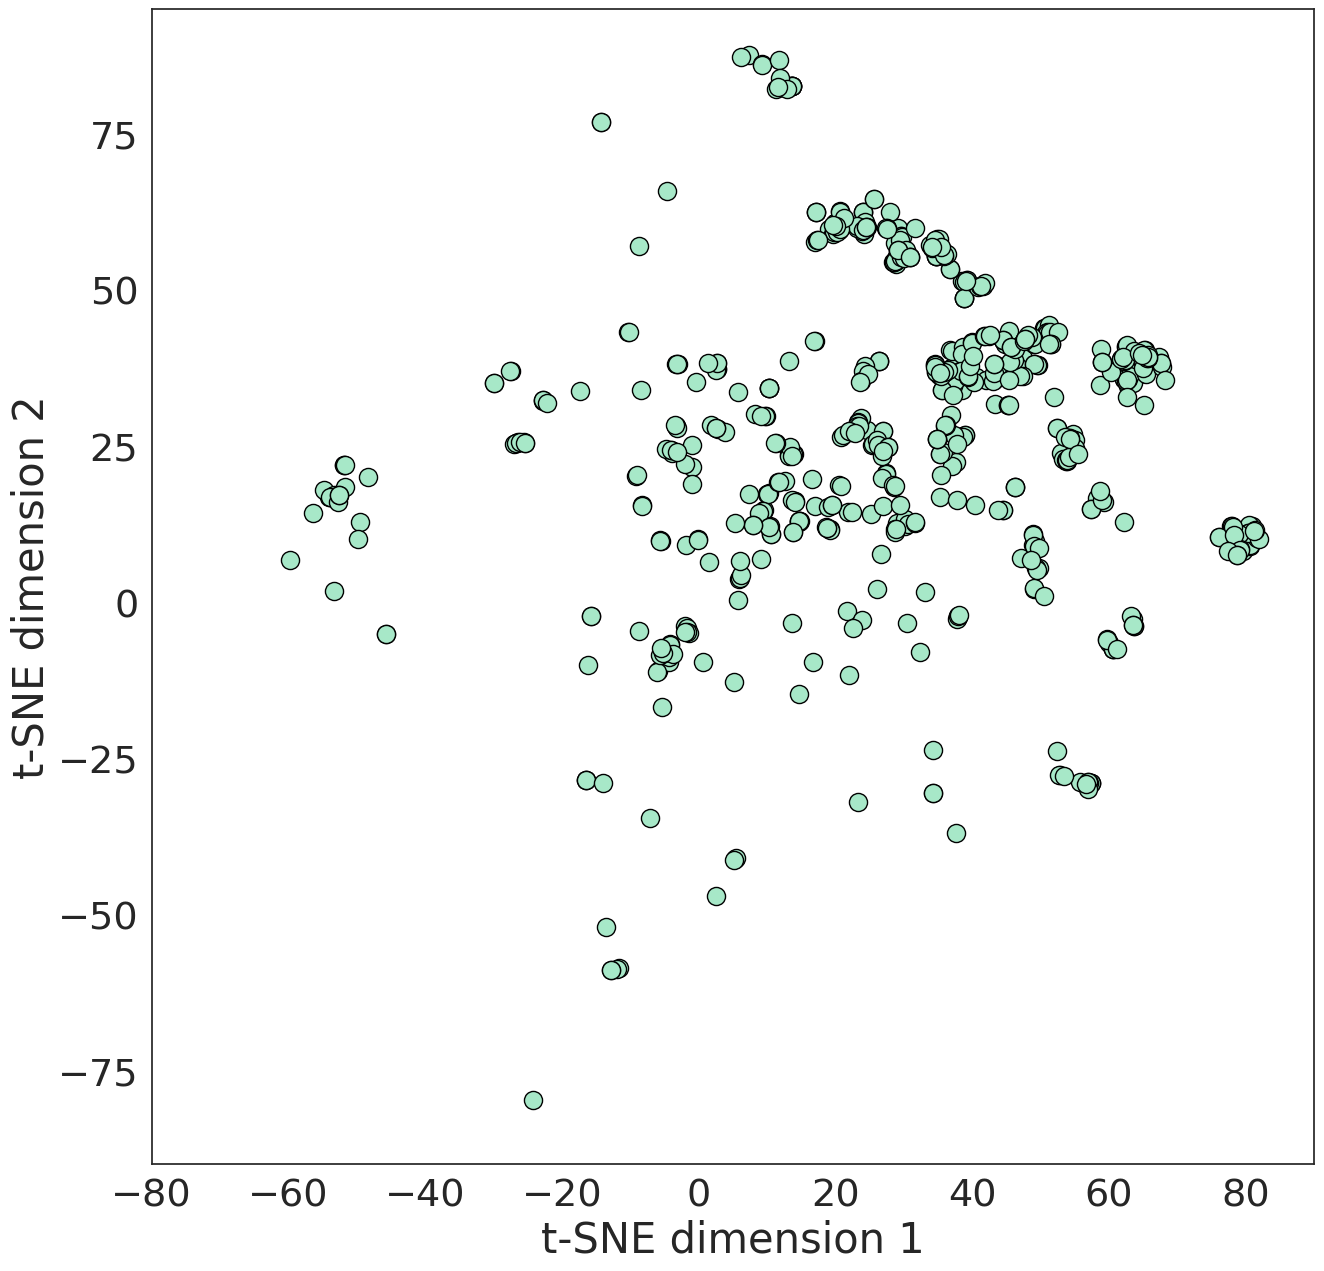

In [ ]:
#Set white background
sns.set_style("white")

#Figure and font sizes
plt.figure()
plt.figure(figsize=(15,15))
plt.xlabel("t-SNE dimension 1", fontsize=30)
plt.ylabel("t-SNE dimension 2", fontsize=30)
sns.set(font_scale=2.5)

#Scatterplot with selected palette
ax = sns.scatterplot(
                x = UNPDA["dimension1"],
                y = UNPDA["dimension2"],
                color=['#A7E8C8'],
                edgecolor = 'black',
                linewidth = 1
                )

ax.set_xlim(-80, 90)
ax.set_ylim(-90, 95)
ax.collections[0].set_sizes([170])

plt.legend().remove()

plt.savefig('alva_tSNE_MACCS_9.png', bbox_inches='tight', dpi=400)